Advanced bifurcation analysis
=============================

The objective of this notebook is to learn how to perform advanced bifurcation analysis. The dataset used is 10X sequencing from the developping (E15.5) enteric nervous system, it includes Schwann Cell precursors and two neuronal population generated via a bifurcation. Raw data is available at [GSE149524](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE149524).


## Importing modules and data

In [1]:
import scvelo as scv
import scanpy as sc
import scFates as scf
scv.settings.verbosity = 3
scv.settings.presenter_view = True
scv.set_figure_params('scvelo',figsize=(5,5))

<div class="alert alert-info">

**Note**    

The pre-processing is not shown here, the loaded data contains the following:

- Raw count matrix generated by cellranger, and RNA background cleaned by CellBender
- PCA and UMAP generated by pagoda2 pipeline on the raw count matrix
- RNA velocity UMAP projection generated via scvelo from dropEst on cellranger BAM files

</div>  

In [2]:
adata = scf.datasets.morarach20()

Let's look at some markers.

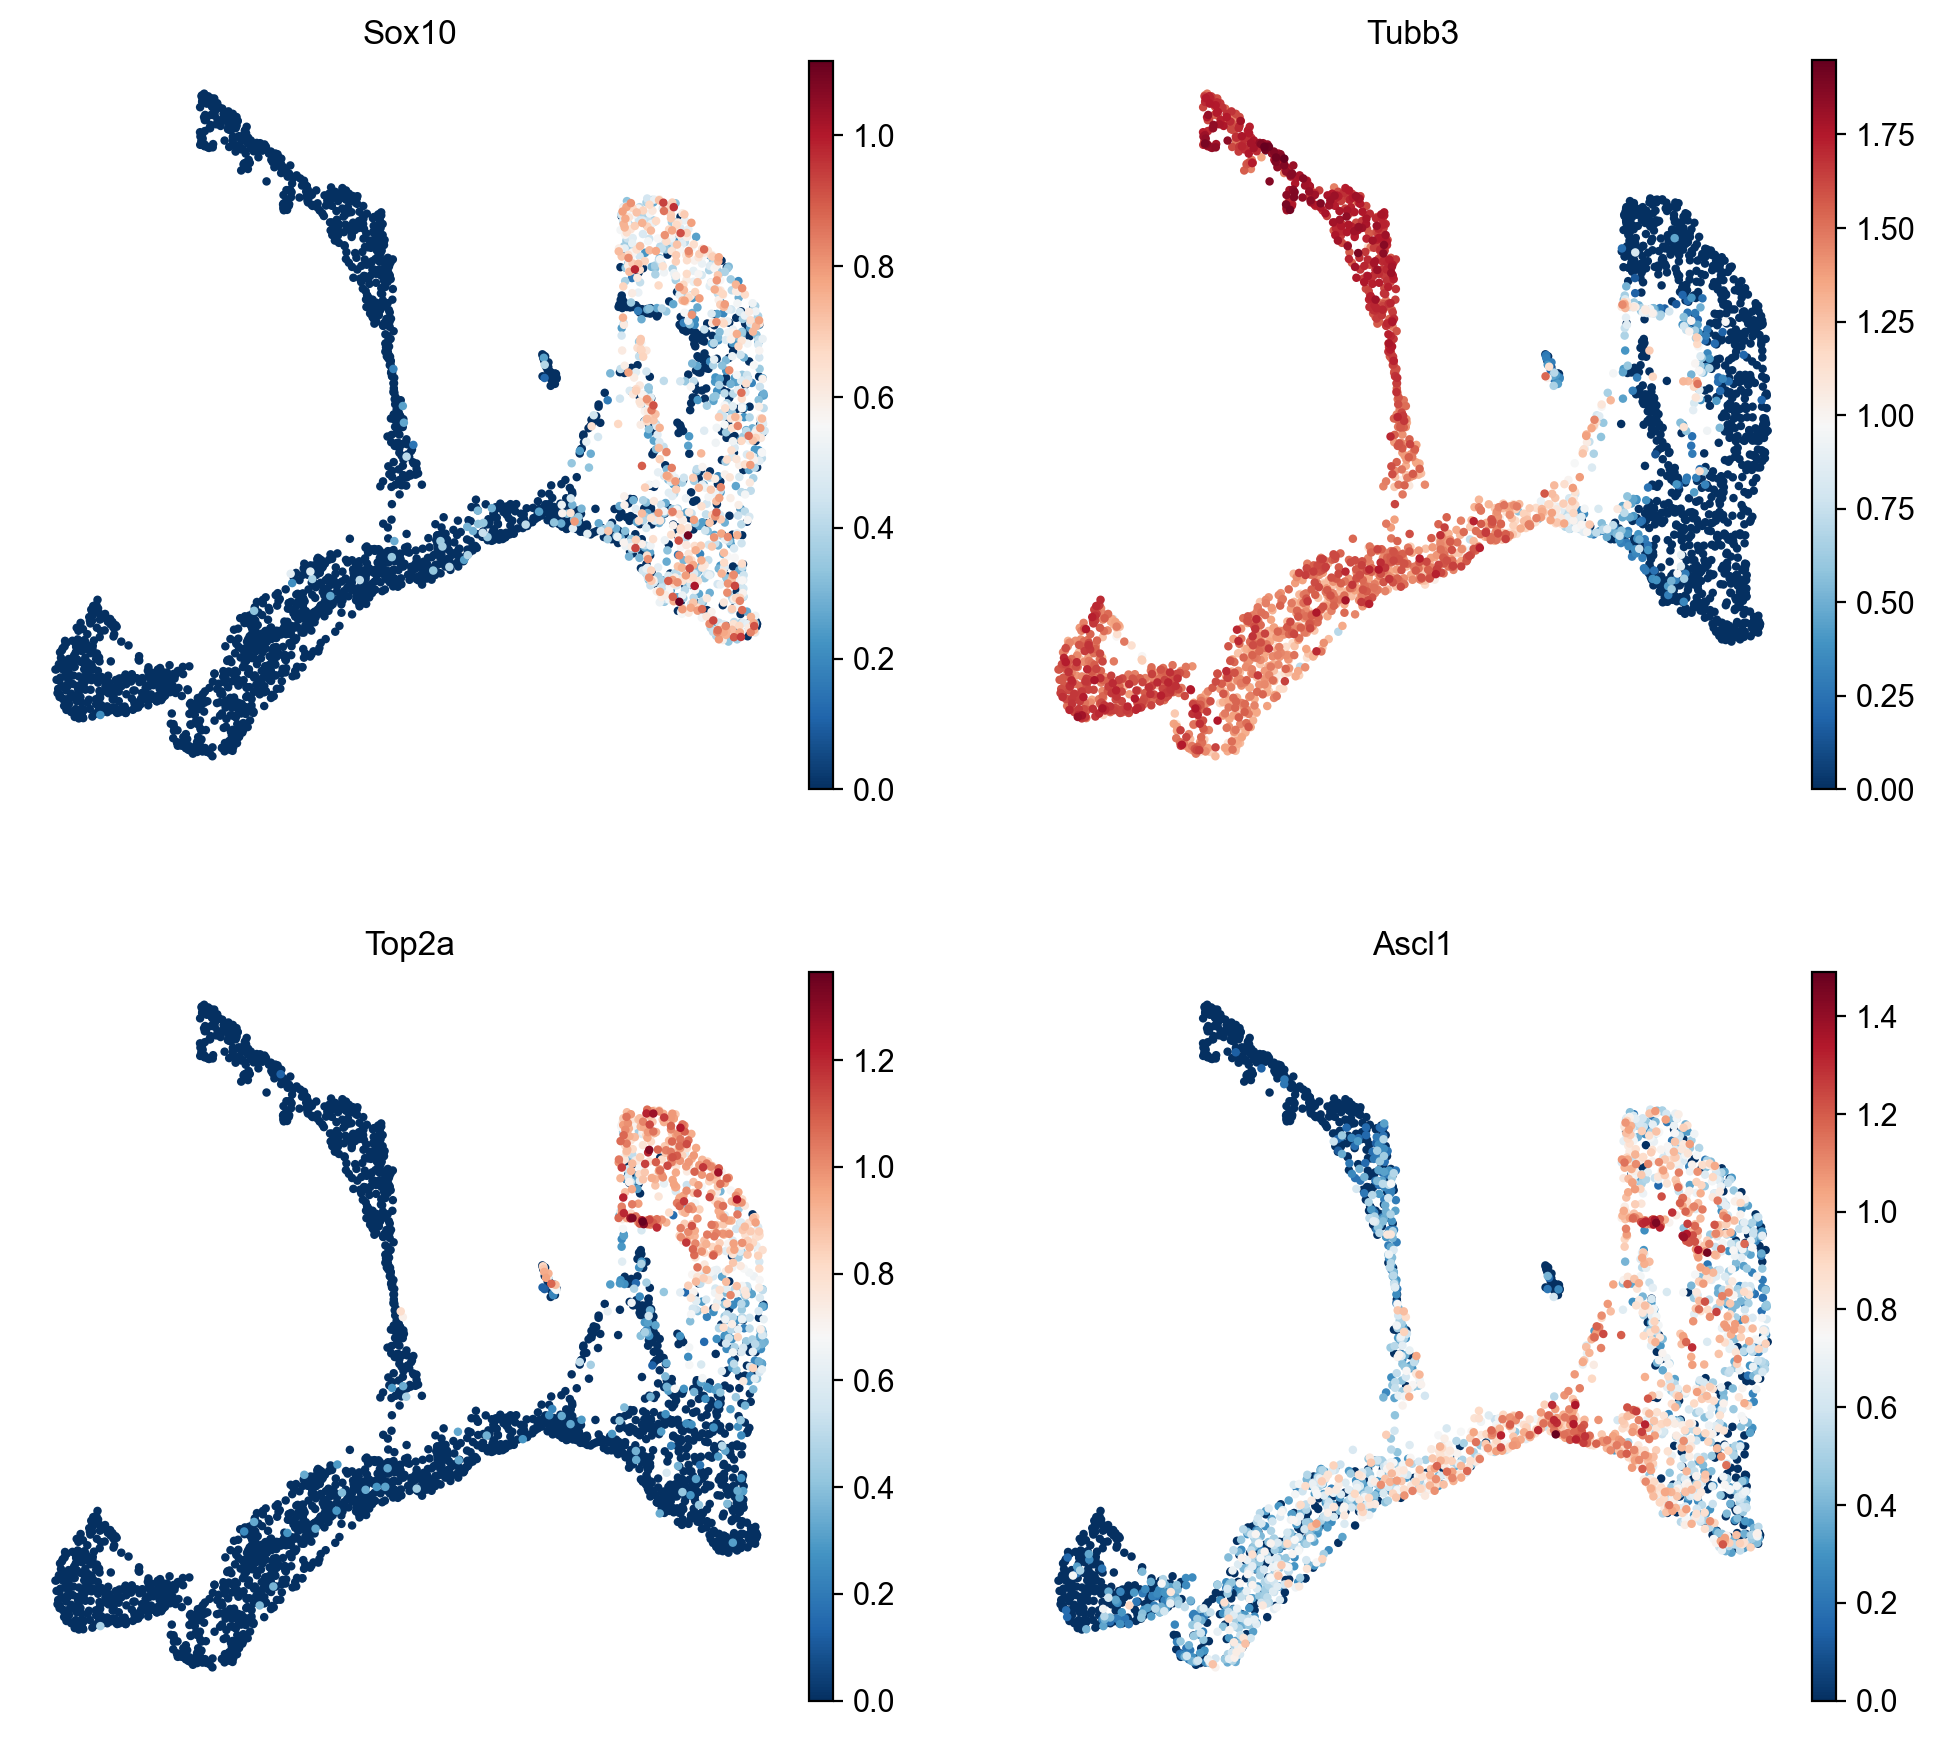

In [3]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata,base=10)
sc.pl.umap(adata,color=["Sox10","Tubb3","Top2a","Ascl1"],ncols=2,frameon=False)

Let's plot the velocity embedding. RNA velocity is not taken in account for the tree building, it only helps to get an idea of the directionality of the data and to manually select a root.

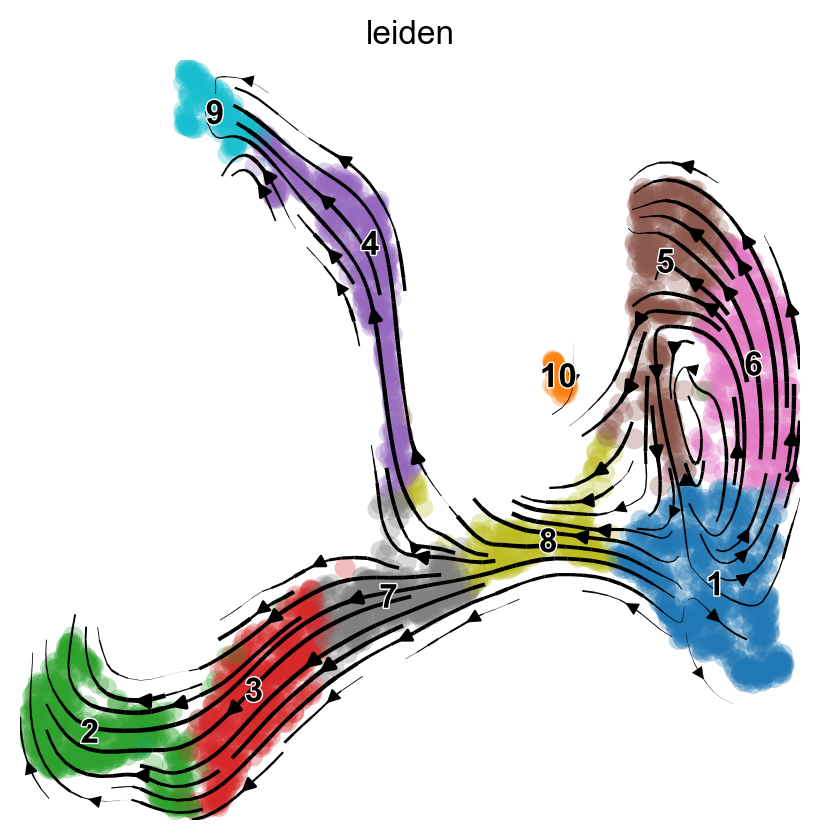

In [4]:
scv.pl.velocity_embedding_stream(adata, basis='umap',color="leiden")

Overall we see a clear transition from cycling Sox10+ SCP to two Tubb3+ neuronal subtypes, with Ascl1 representing the bridge before the bifurcation.

## Fit tree and extract significant features

### Fitting tree using SimplePPT

We will infer a principal tree on PCA space using SimplePPT method.

In [5]:
scf.tl.tree(adata,Nodes=300,use_rep="pca",method="ppt",device="gpu",ppt_sigma=1,ppt_lambda=10000,seed=1)

inferring a principal tree --> parameters used 
    300 principal points, sigma = 1, lambda = 10000, metric = euclidean
    fitting:  68%|██████▊   | 34/50 [00:03<00:01,  9.33it/s]
    converged
    finished (0:00:07) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['R'] soft assignment of cells to principal point in representation space.
    .uns['graph']['F'] coordinates of principal points in representation space.


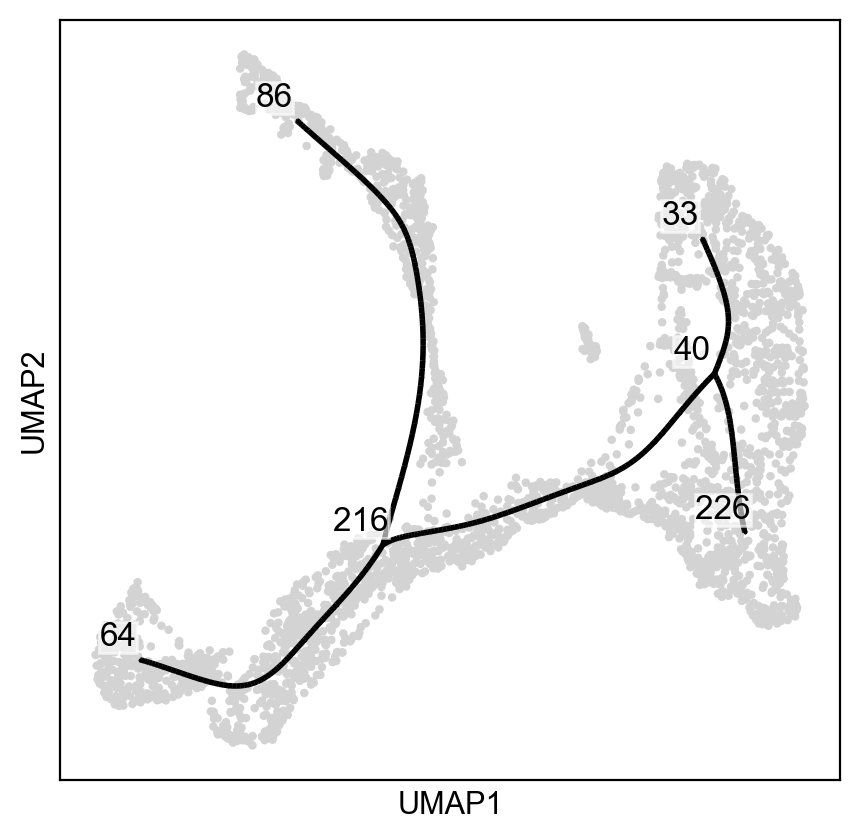

In [6]:
scf.pl.graph(adata,size_nodes=.1)

### Root selection and pseudotime calculation

In [7]:
scf.tl.root(adata,40)

root selected --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.


In [8]:
scf.tl.pseudotime(adata)

projecting cells onto the principal graph
    finished (0:00:01) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


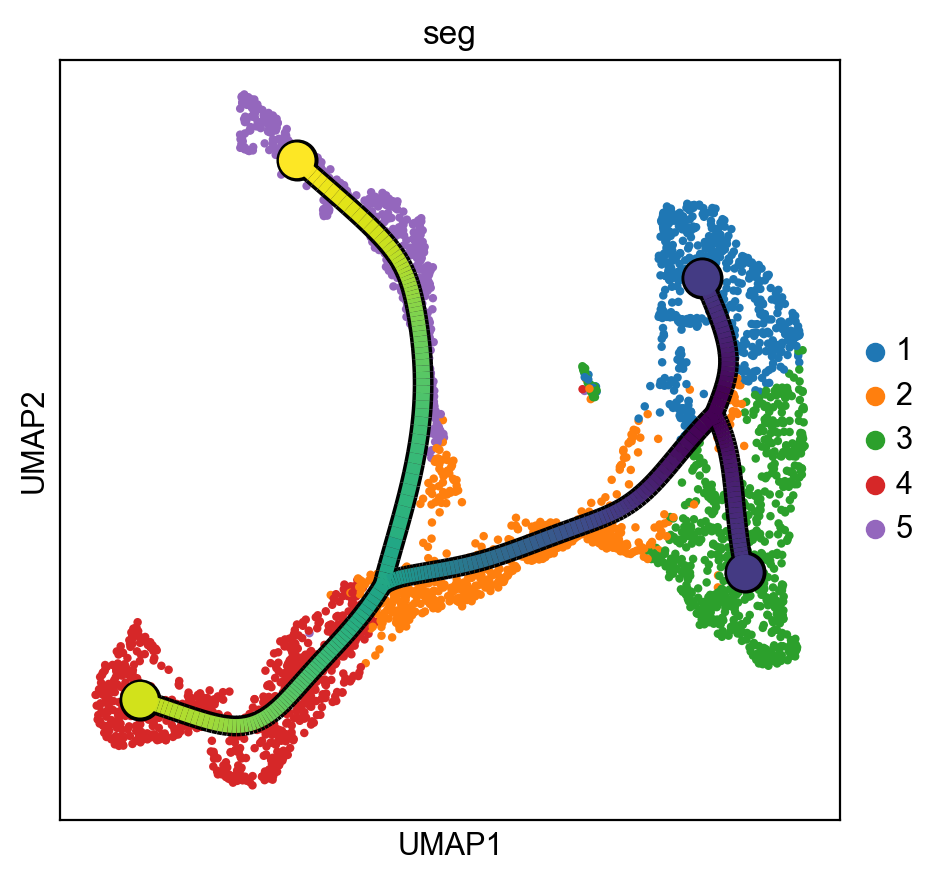

In [9]:
scf.pl.trajectory(adata,color_cells="seg")

In [10]:
sc.pl.umap(adata,color="t",color_map="viridis")

### Features testing and fitting

In [11]:
scf.tl.test_association(adata,n_jobs=40,A_cut=.3)

test features for association with the trajectory
    mapping 0: 100%|██████████| 16934/16934 [02:55<00:00, 96.58it/s] 
    found 1142 significant features (0:02:56) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


In [12]:
scf.pl.test_association(adata)

In [13]:
scf.tl.fit(adata,n_jobs=40)

fit features associated with the trajectory
    mapping 0: 100%|██████████| 1142/1142 [00:17<00:00, 66.42it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:20) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


### Plotting milestones



<div class="alert alert-info">

**Note**    

Milestones are not a result of a clustering, these labels mark cells to their closest tip or fork on the tree. This labelling will help for selecting branches for performing bifurcation analysis.

</div>  

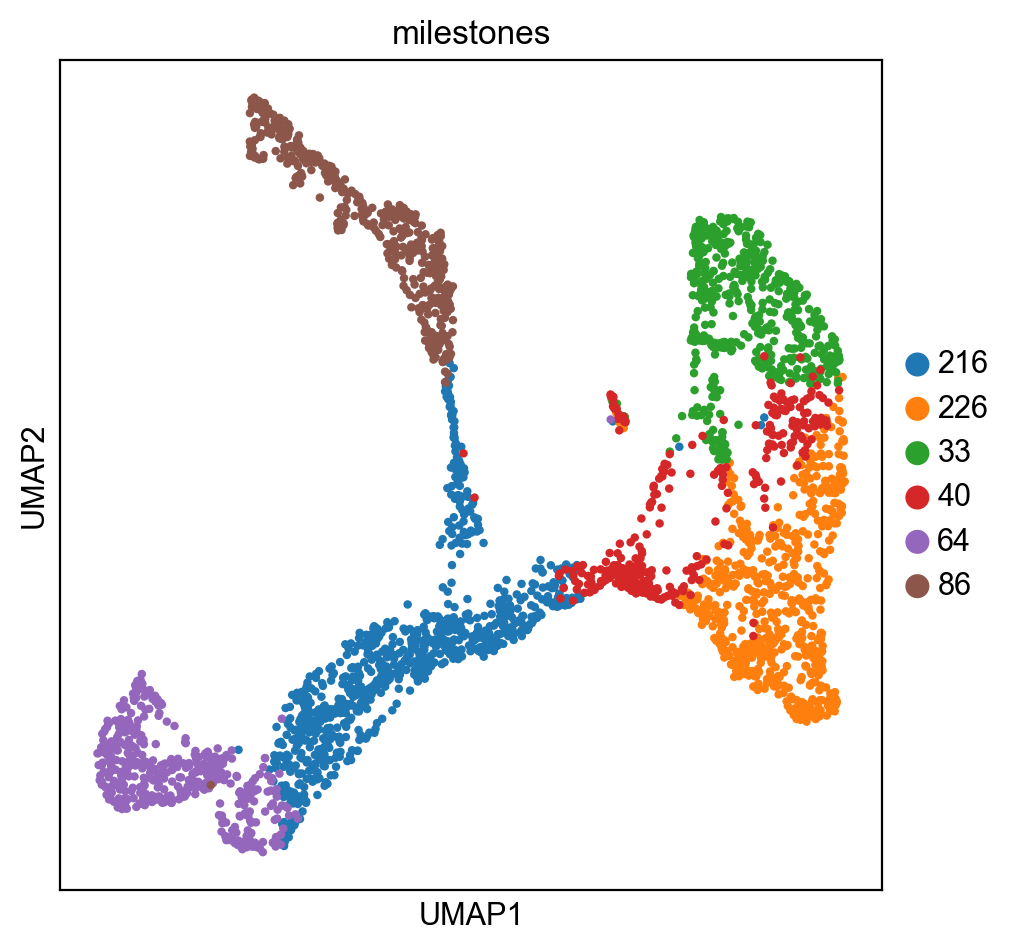

In [14]:
sc.pl.scatter(adata,basis="umap",color="milestones")

Let's rename the milestones according to biological knowledge, the order of the renamed milestones should follow the order of the legend or the one shown with:
**.obs.milestones.cat.categories**

In [15]:
mil=["bifurcation","glia","cycling","root","EN1","EN2"]
scf.tl.rename_milestones(adata,mil)

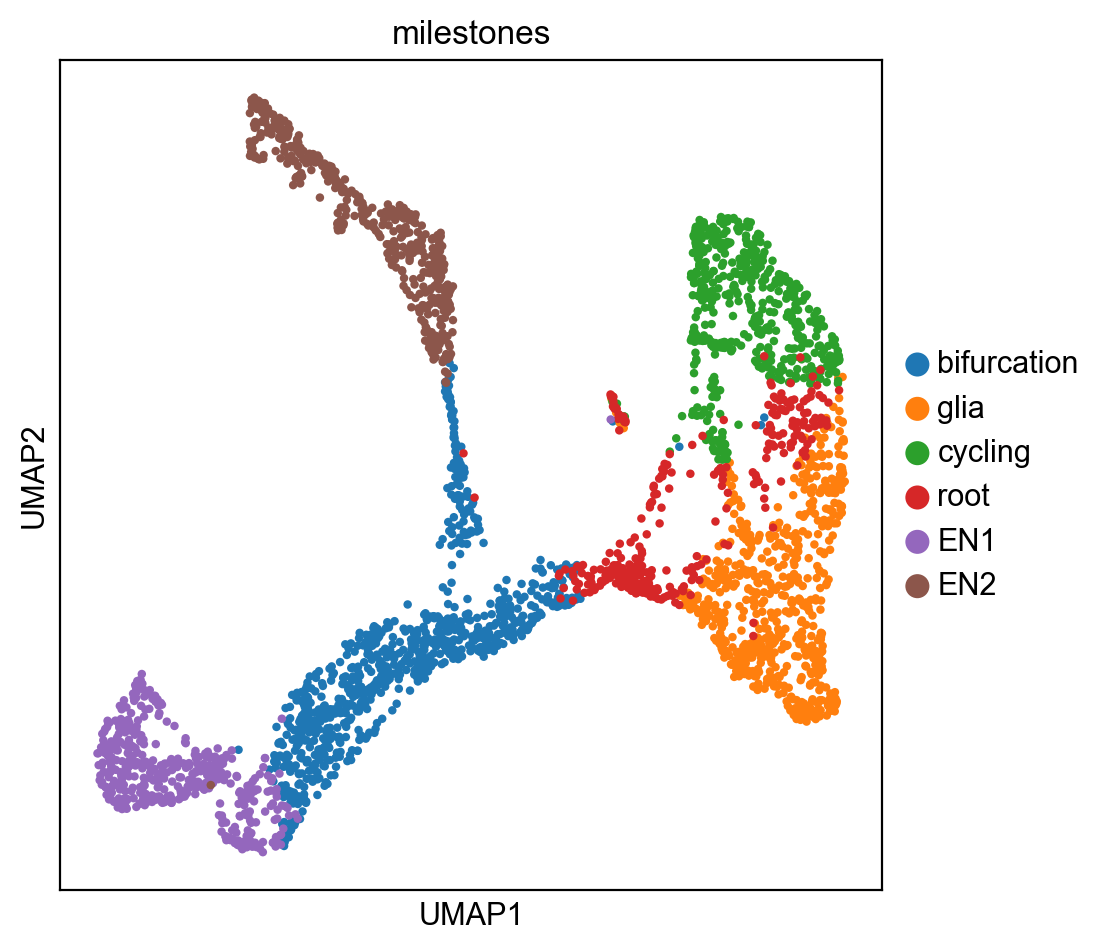

In [16]:
sc.pl.scatter(adata,basis="umap",color="milestones")

We can also represent the milestones in a directed PAGA style :)

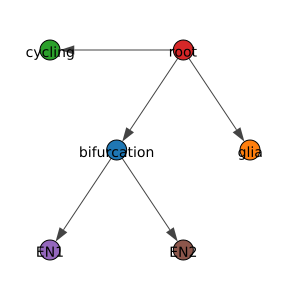

In [17]:
scf.pl.milestones(adata,figsize=(300,300),roots=["root","cycling"])

## Bifurcation analysis

We now focus on the bifurcation between the two neuronal types:

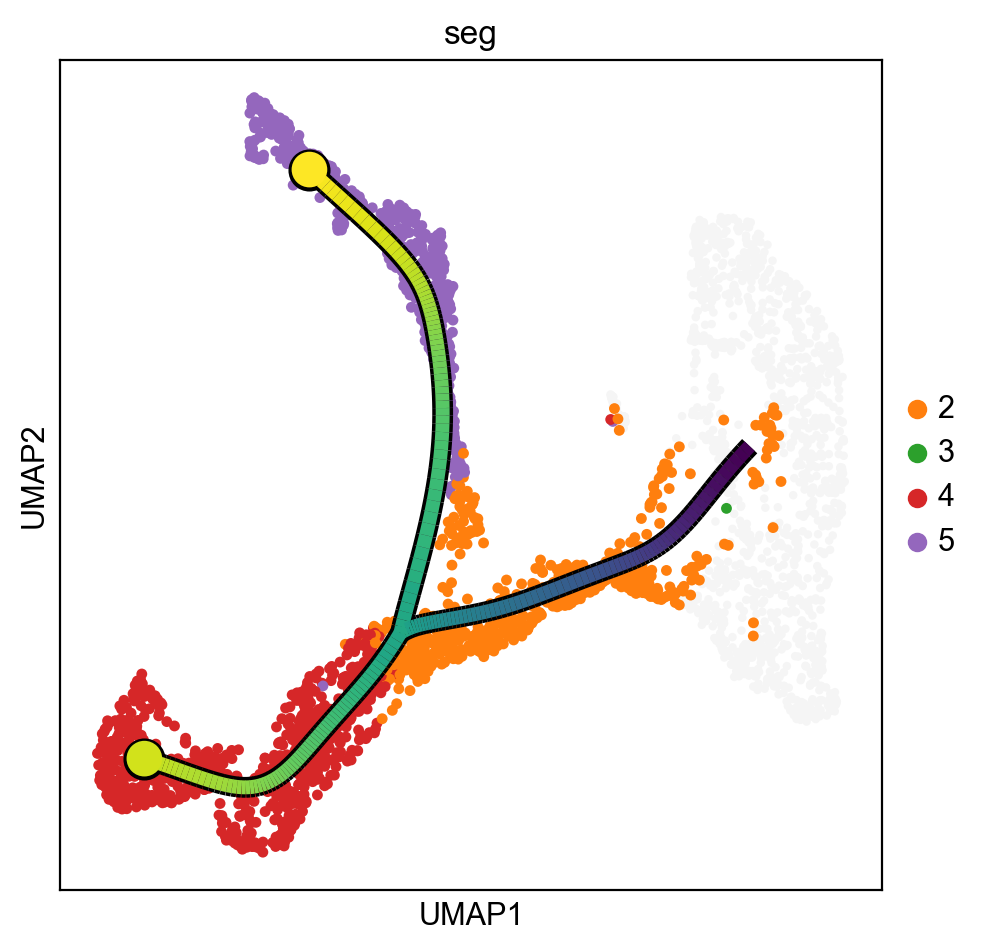

In [18]:
scf.pl.trajectory(adata,root_milestone="root",milestones=["EN1","EN2"],color_cells="seg")

### Testing all features for branch-specificity and upregulation from progenitor branch 

Let's do differential gene expression between two branches, we also need to determine which genes are differentially upregulated after bifurcation point.

In [19]:
scf.tl.test_fork(adata,root_milestone="root",milestones=["EN1","EN2"],n_jobs=20,rescale=True)

testing fork
    mapping: 0
    differential expression: 100%|██████████| 1142/1142 [00:25<00:00, 45.25it/s]
    test for upregulation for each leave vs root
    leave EN2: 100%|██████████| 644/644 [00:02<00:00, 269.31it/s]
    finished (0:00:30) --> added 
    .uns['root->EN1<>EN2']['fork'], DataFrame with fork test results.


We estimate branch-specifc features by applying a threshold on the difference of amplitude compared to the other branch.

In [20]:
scf.tl.branch_specific(adata,root_milestone="root",milestones=["EN1","EN2"],effect=0.2)

    branch specific features: EN2: 61, EN1: 23
    finished --> updated 
    .uns['root->EN1<>EN2']['fork'], DataFrame updated with additionnal 'branch' column.


### Inferring activation pseudotime of branch-specific modules

Here we want to classify genes that gets activated before the bifurcation as early genes. This group of genes are of particular interest as they might help to identify early biasing.

In [21]:
scf.tl.activation(adata,root_milestone="root",milestones=["EN1","EN2"],n_jobs=20)

testing activation
    leave EN2: 100%|██████████| 61/61 [00:00<00:00, 336.48it/s]
    threshold pseudotime is: 26.166683857353956
    21 early and 2 late features specific to leave EN1
    42 early and 19 late features specific to leave EN2
    finished (0:00:04) --> updated 
    .uns['root->EN1<>EN2']['fork'], DataFrame updated with additionnal 'activation' and 'module' columns.


The results are accessible as a pandas DataFrame:

In [22]:
adata.uns['root->EN1<>EN2']["fork"].head()

EN1  EN2           de_p            fdr  signi_p  signi_fdr  \
Khdrbs2 -0.226442  0.0   2.596370e-61   2.965054e-58      1.0        1.0   
Tmeff2  -0.253242  0.0   3.453321e-52   3.943692e-49      1.0        1.0   
Resp18  -0.215956  0.0   1.413482e-19   1.614197e-16      1.0        1.0   
Proser2 -0.231765  0.0   5.384864e-85   6.149515e-82      1.0        1.0   
Ass1    -0.799688  0.0  4.931360e-218  5.631614e-215      1.0        1.0   

             up_A           up_p branch  activation module  
Khdrbs2  0.012112  3.220187e-135    EN2   22.142809  early  
Tmeff2   0.004891   2.620581e-12    EN2    5.751527  early  
Resp18   0.018722  5.779455e-206    EN2   36.808693   late  
Proser2  0.008571   8.867580e-97    EN2   25.593605  early  
Ass1     0.016423   1.276501e-23    EN2    7.476925  early

### Plotting gene modules

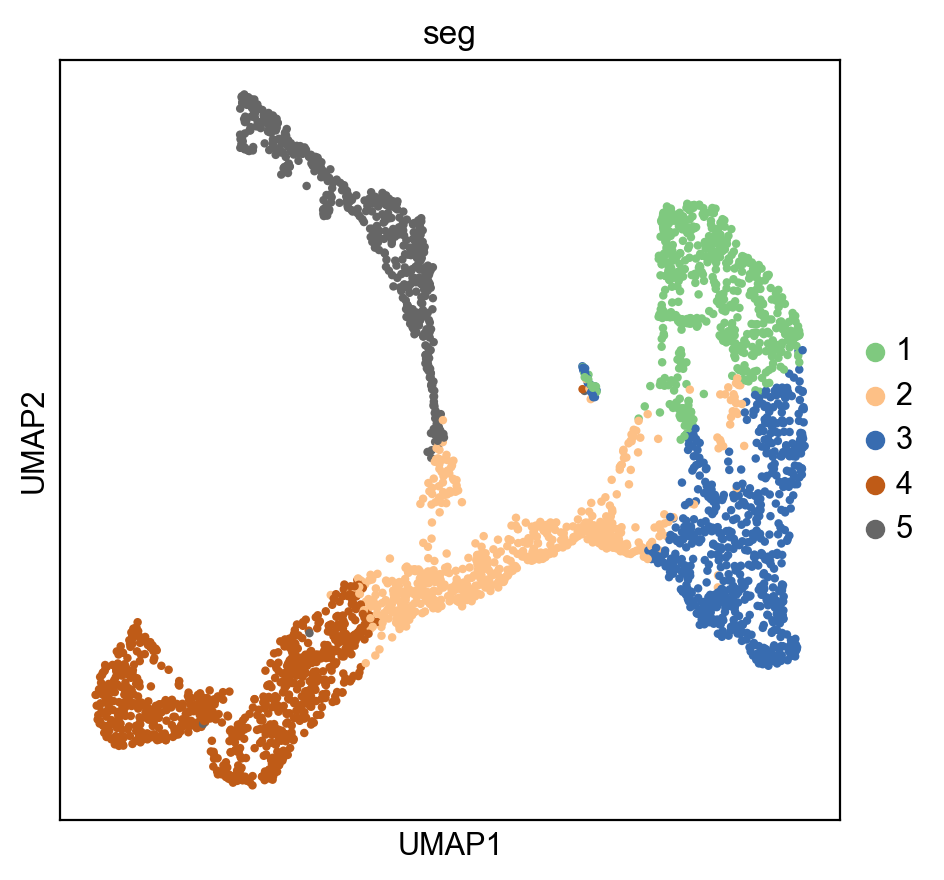

In [23]:
sc.pl.umap(adata,color="seg",palette="Accent")

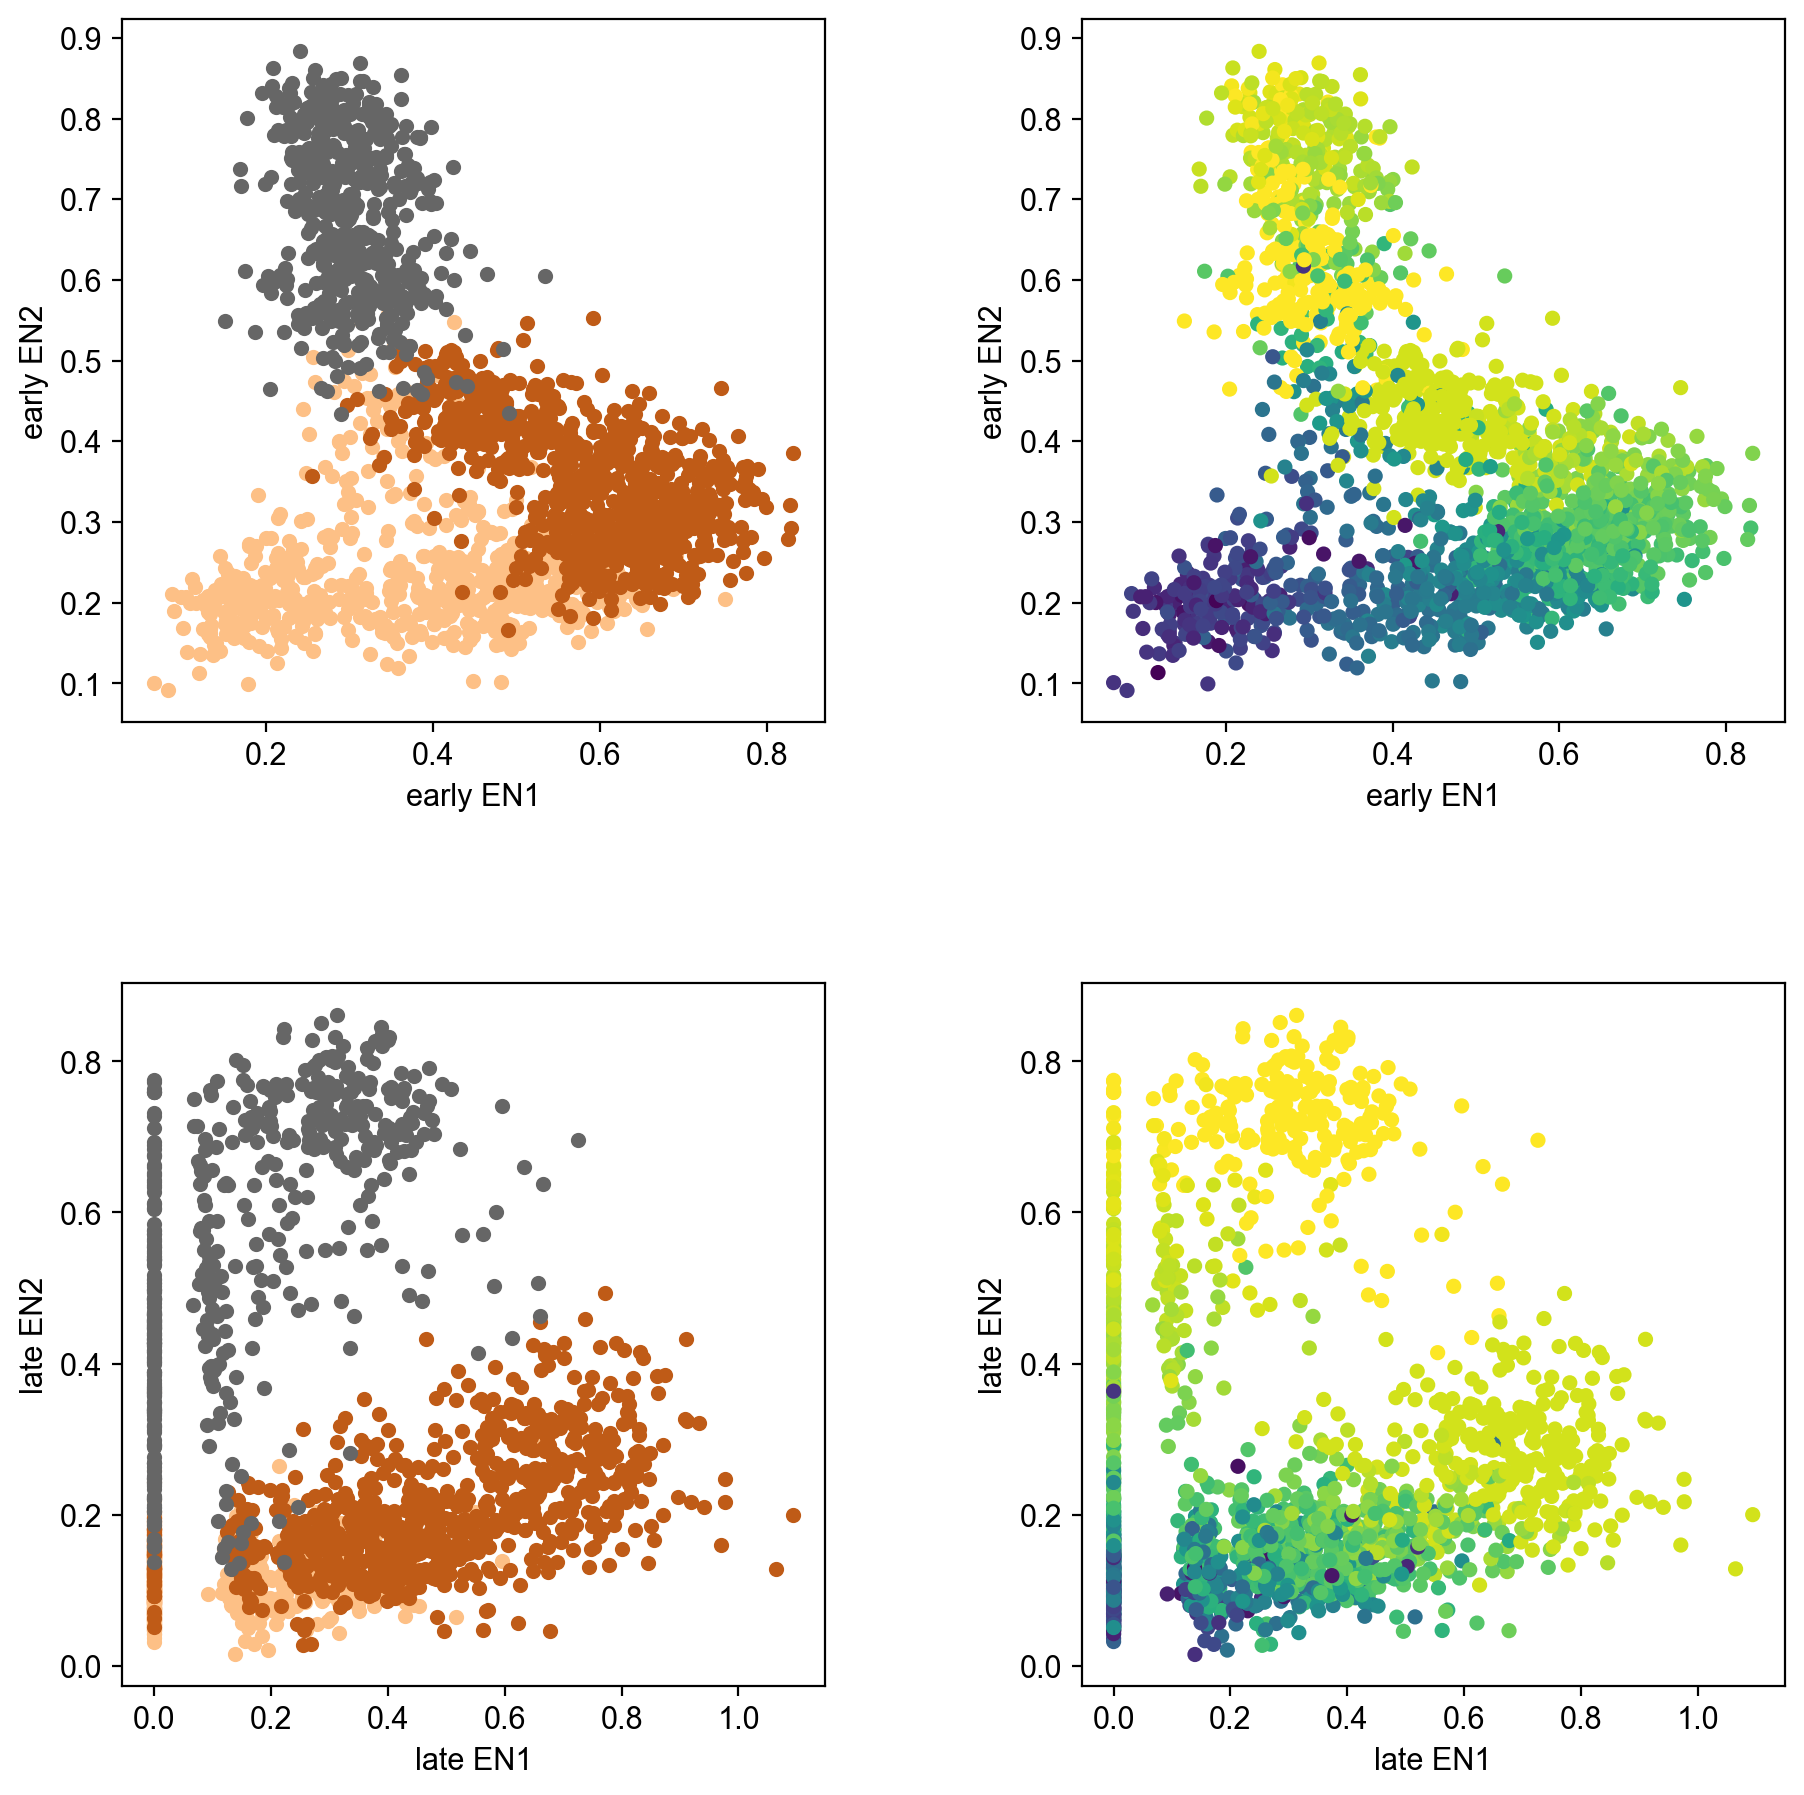

In [24]:
scf.pl.modules(adata,root_milestone="root",milestones=["EN1","EN2"],color="seg")

<div class="alert alert-info">

**Note**    

By default, cells are colored according to their milestone.

</div>  

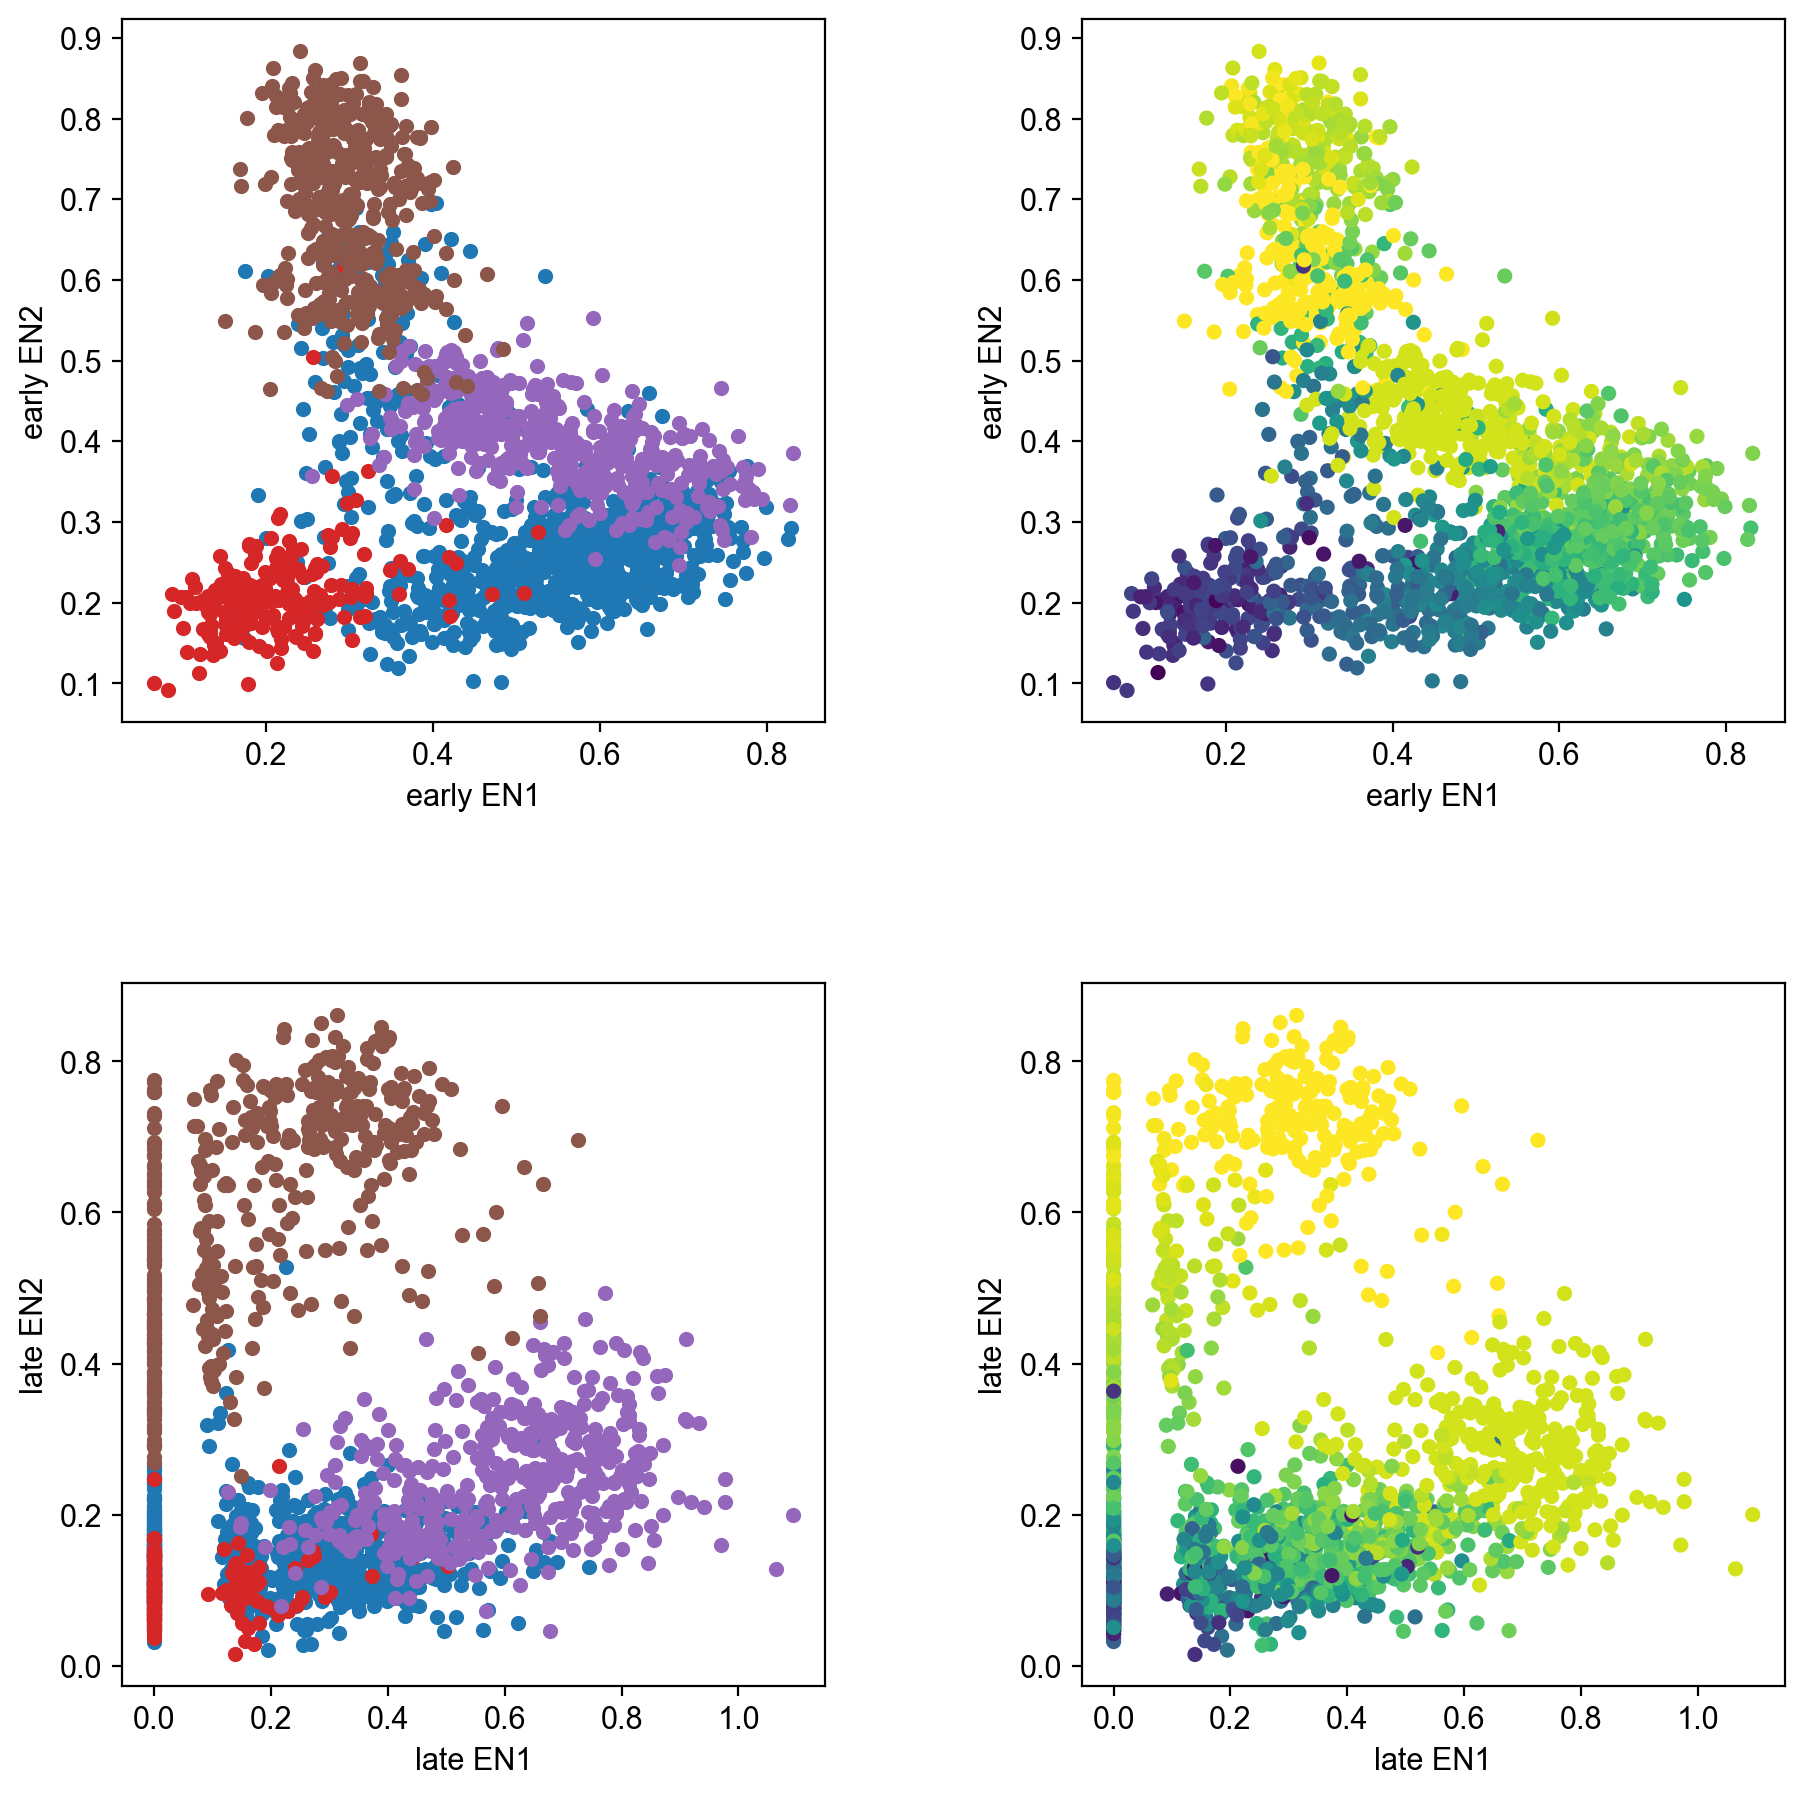

In [25]:
scf.pl.modules(adata,root_milestone="root",milestones=["EN1","EN2"])

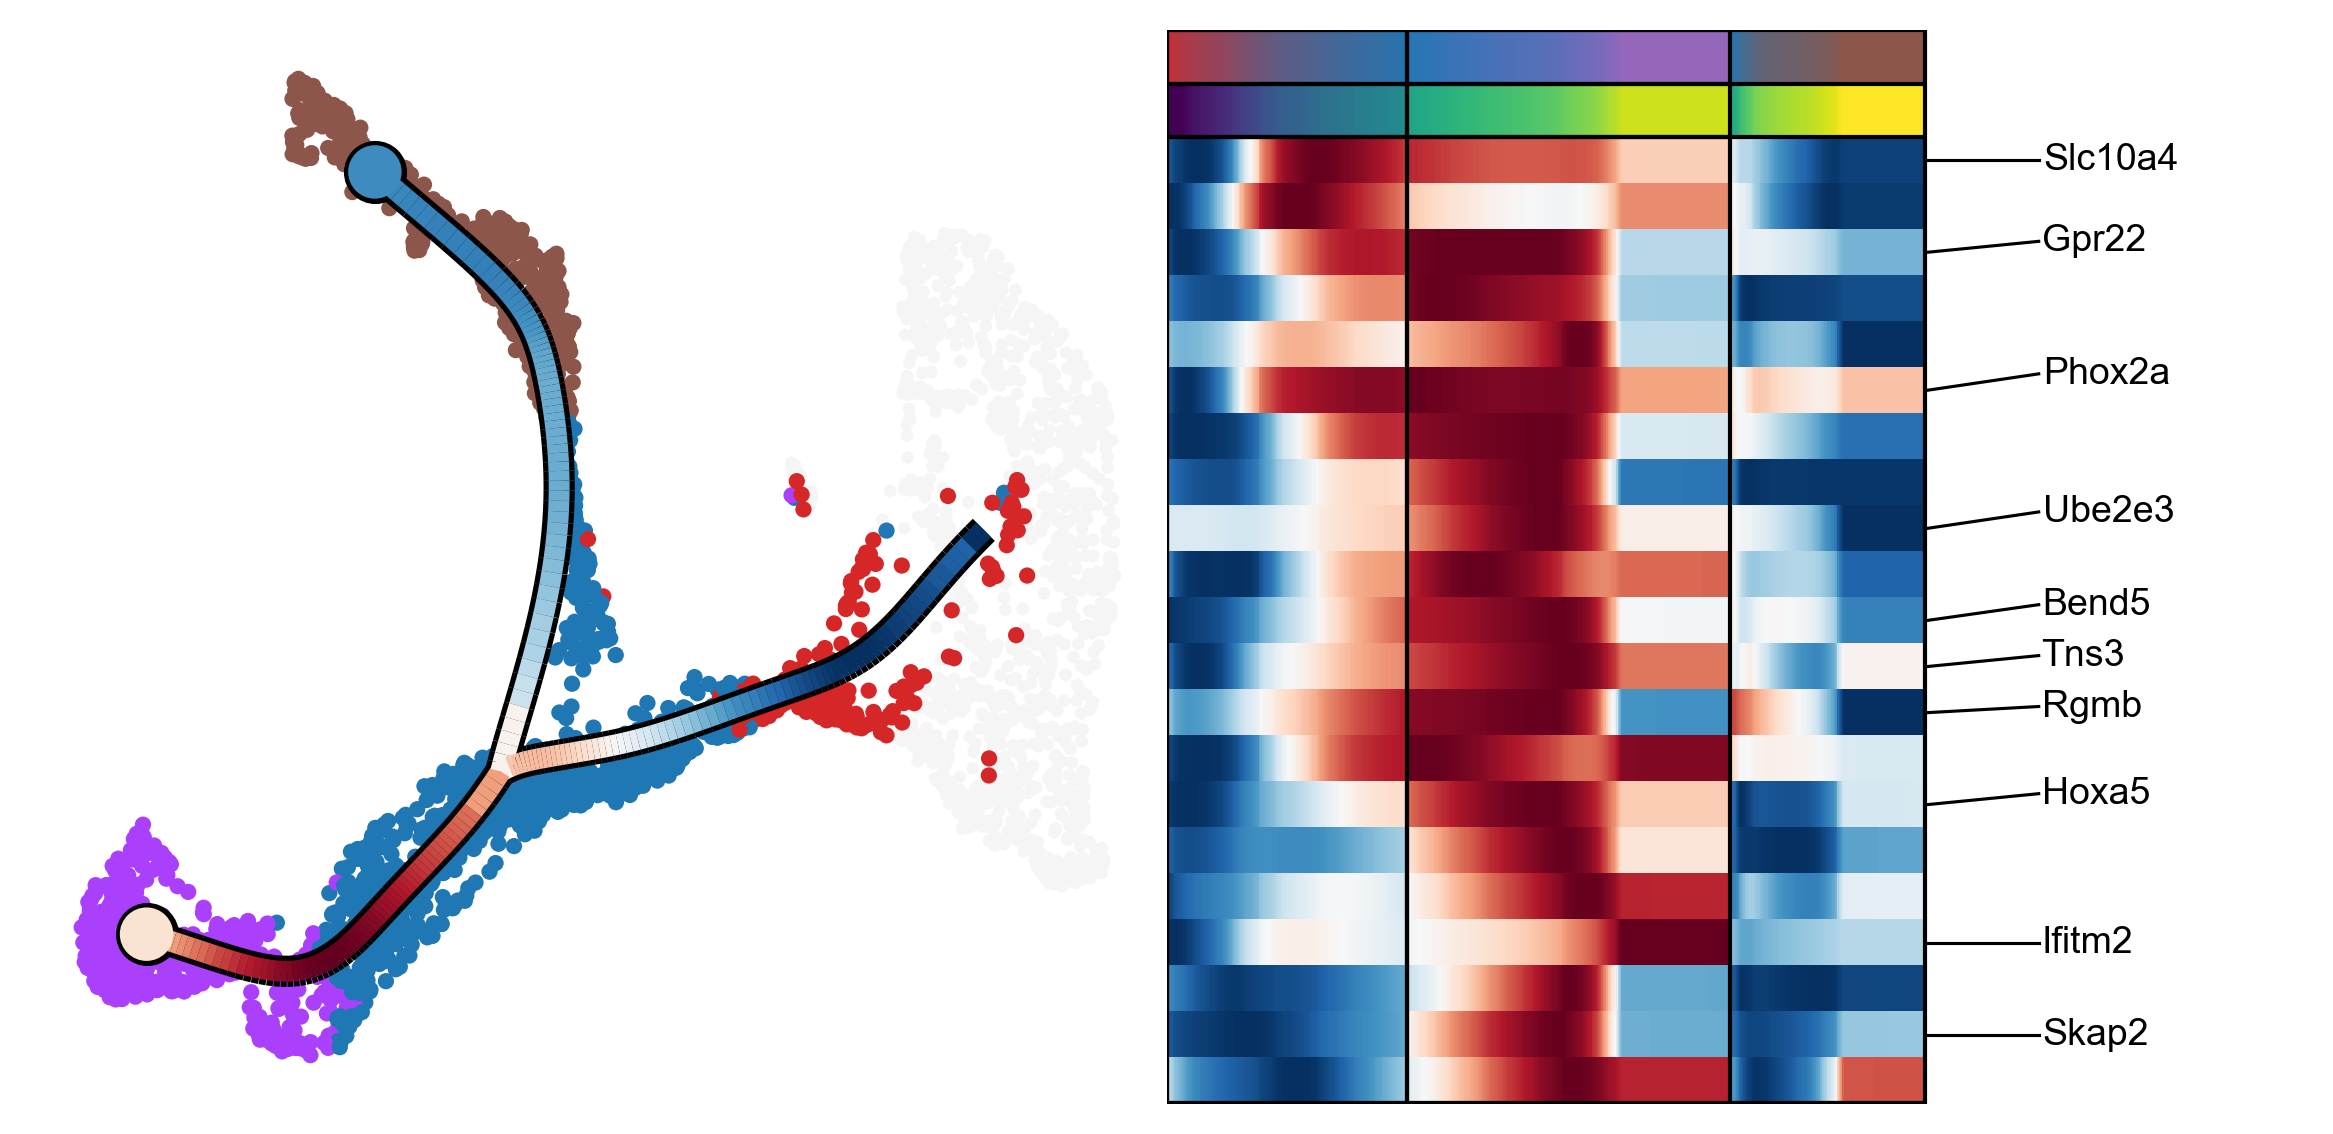

In [26]:
df=adata.uns['root->EN1<>EN2']['fork']
sc.set_figure_params(dpi=150)
scf.pl.trends(adata,features=df.index[(df.module=="early") & (df.branch=="EN1")],
              plot_emb=True,annot="milestones",
              filter_complex=False,ordering="pearson",
              root_milestone="root",milestones=["EN1","EN2"],frameon=False)

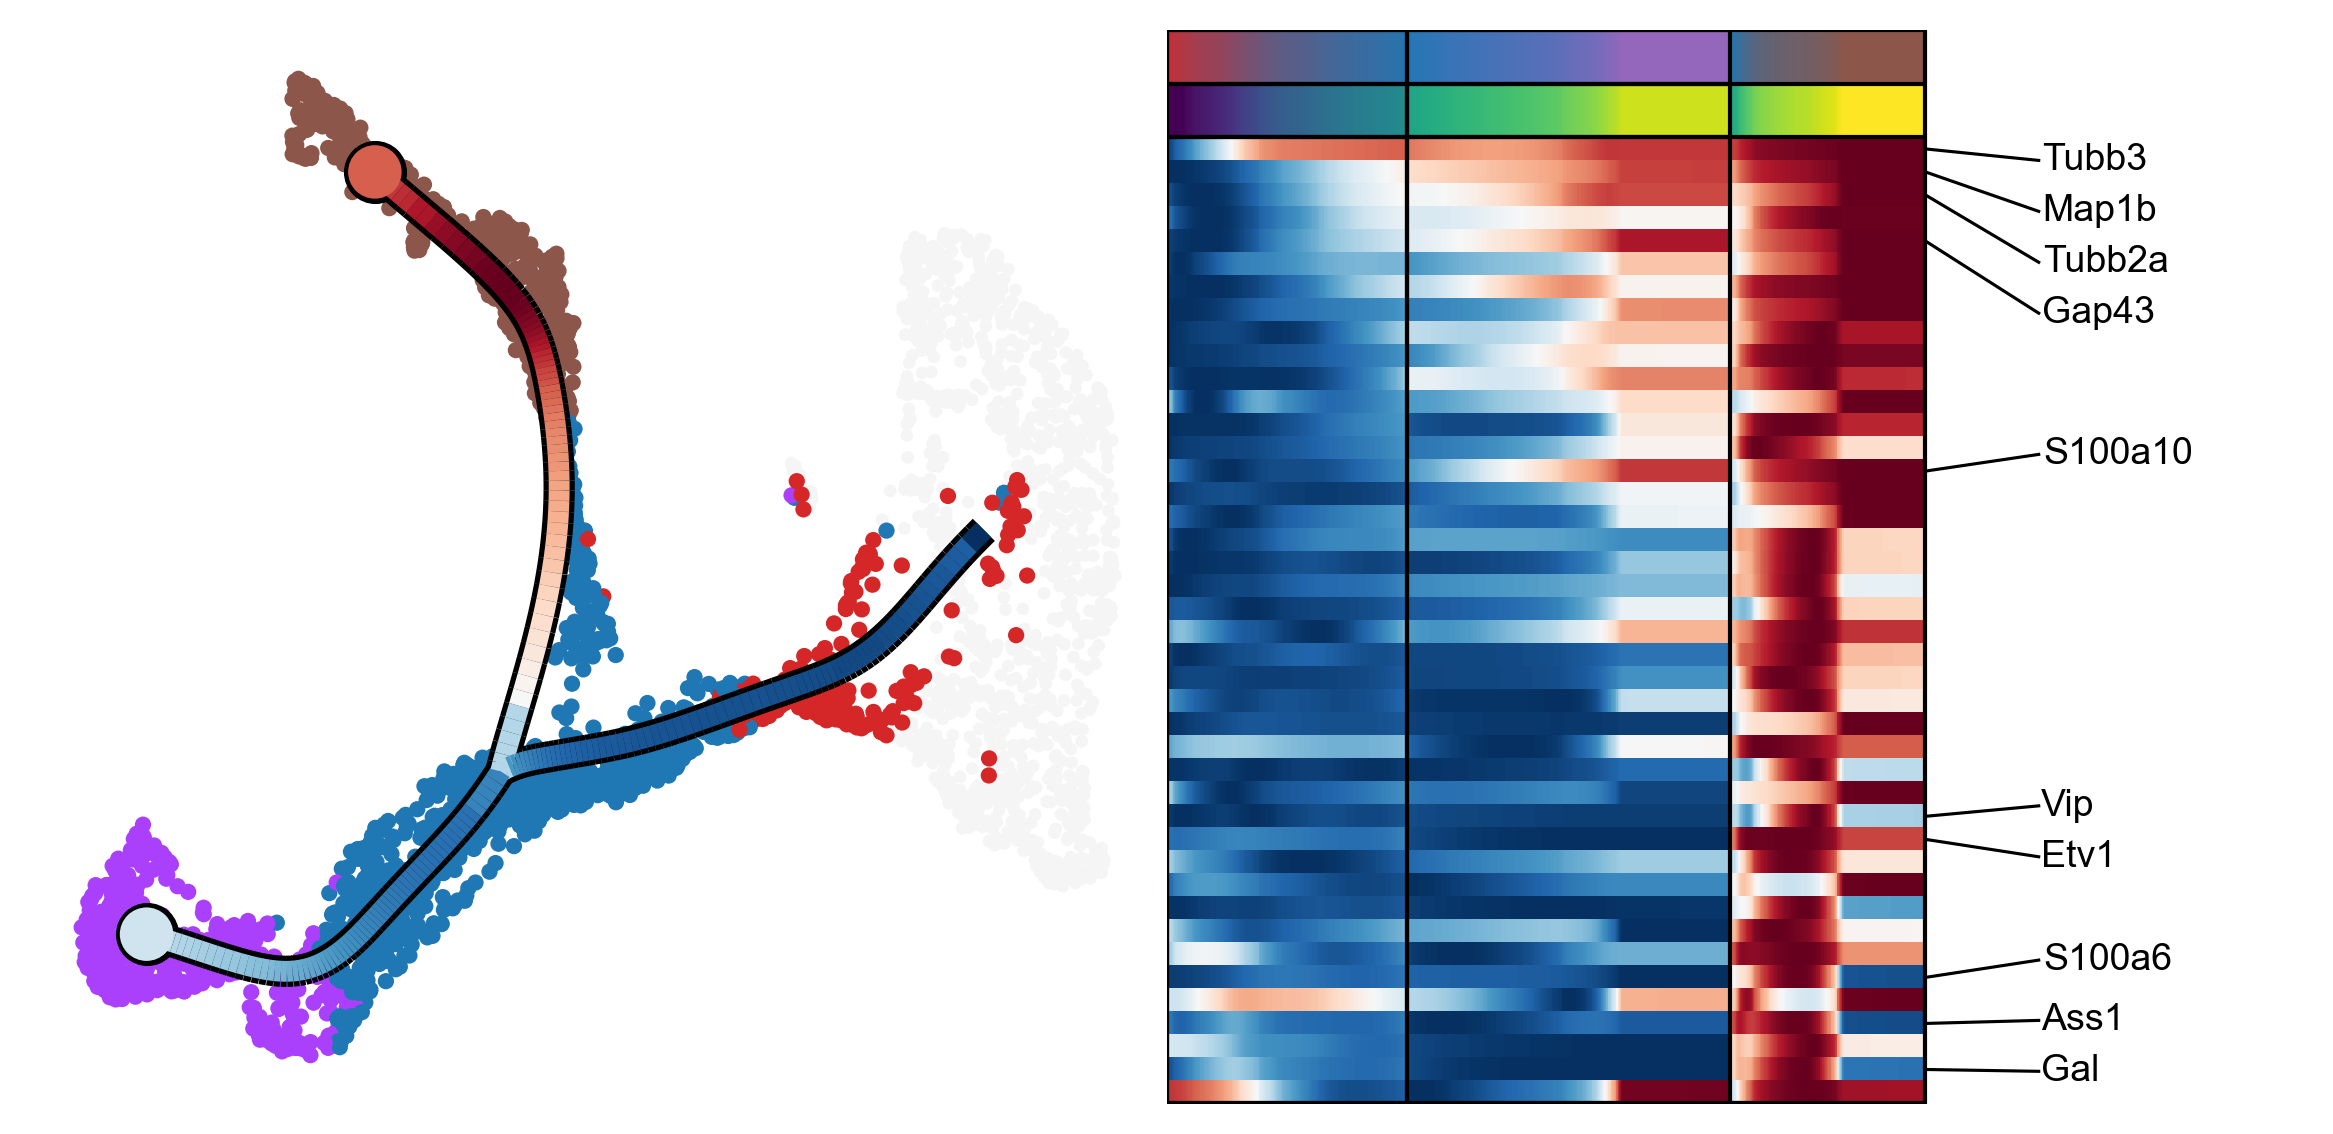

In [27]:
scf.pl.trends(adata,features=df.index[(df.module=="early") & (df.branch=="EN2")],
              plot_emb=True,annot="milestones",
              filter_complex=False,ordering="pearson",
              root_milestone="root",milestones=["EN1","EN2"],frameon=False)

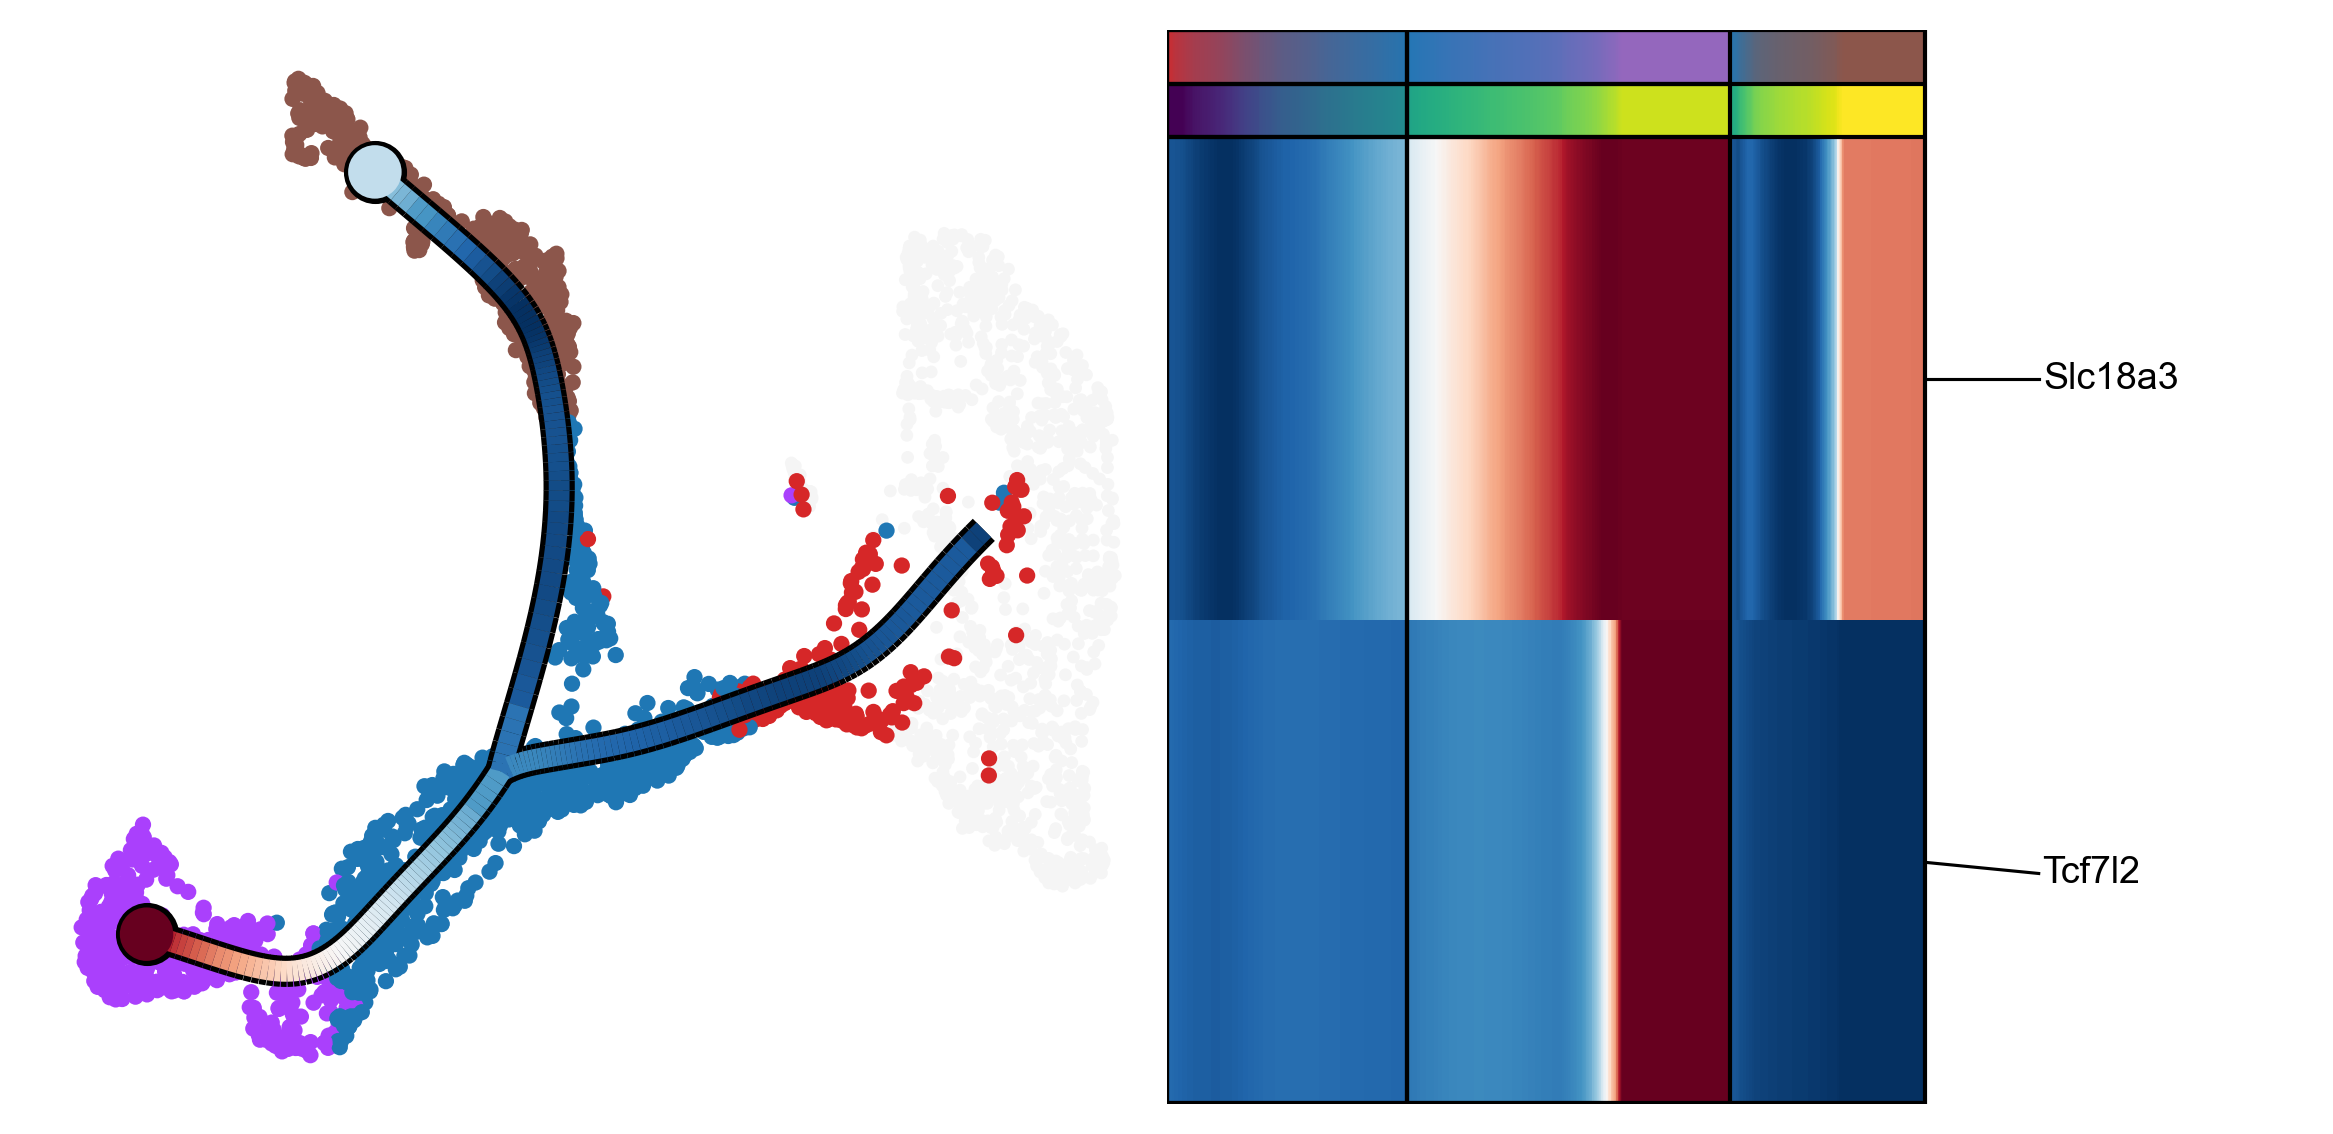

In [28]:
scf.pl.trends(adata,features=df.index[(df.module=="late") & (df.branch=="EN1")],
              plot_emb=True,annot="milestones",
              filter_complex=False,ordering="pearson",
              root_milestone="root",milestones=["EN1","EN2"],frameon=False)

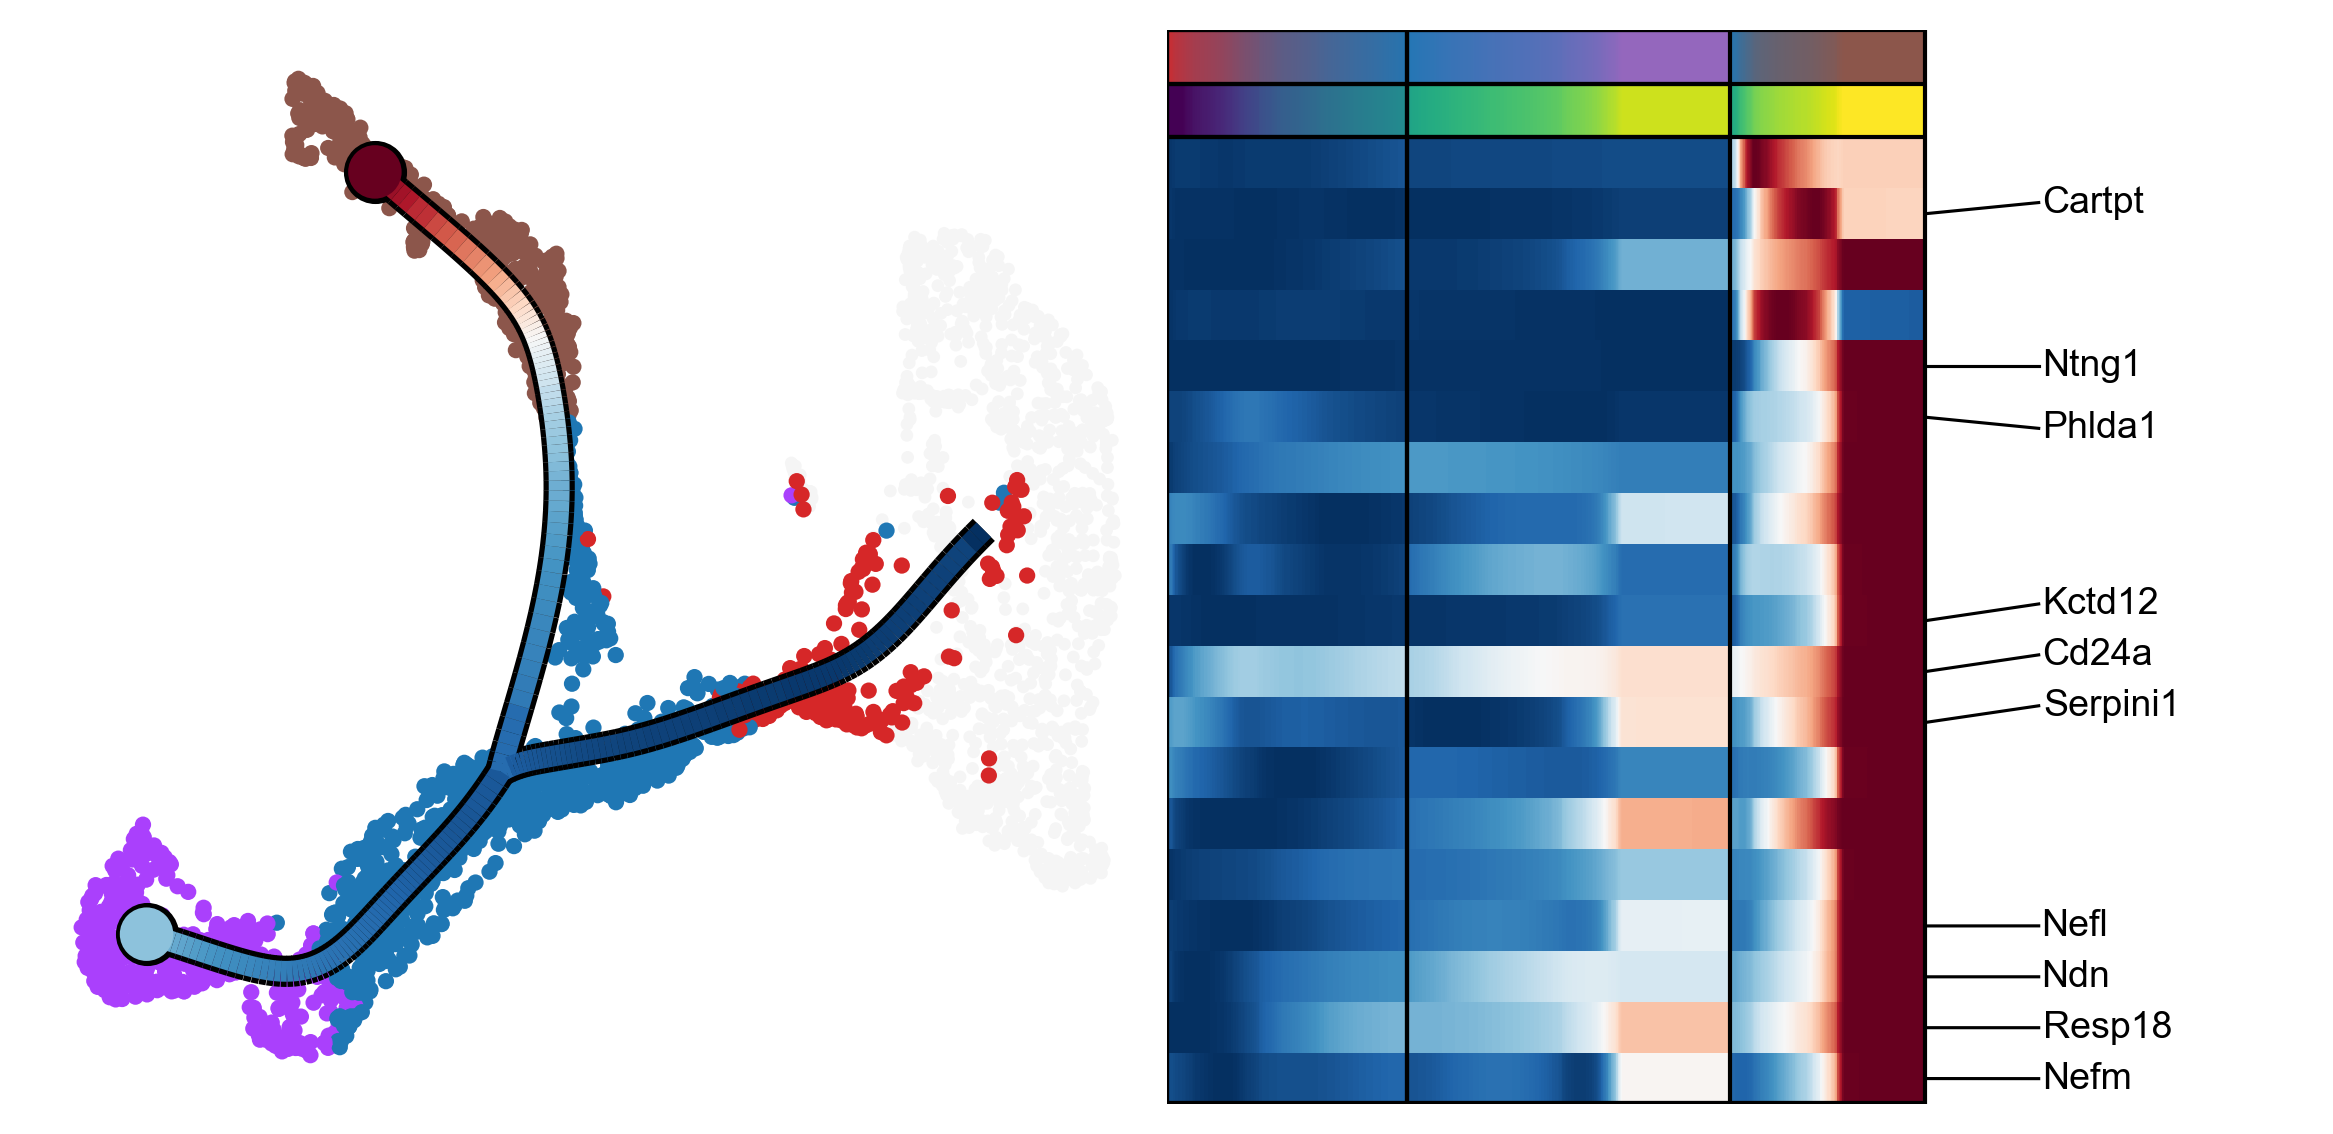

In [29]:
scf.pl.trends(adata,features=df.index[(df.module=="late") & (df.branch=="EN2")],
              plot_emb=True,annot="milestones",
              filter_complex=False,ordering="pearson",
              root_milestone="root",milestones=["EN1","EN2"],frameon=False)

## Early gene modules correlation analysis

Now let's look more precisely at the local intra and inter-module correlations, using the early genes.The aim is to identify whether the modules are competing prior the bifurcation.

### Repulsion of gene modules

For that we need to create non-interesecting windows of cells along the tree:

In [30]:
scf.tl.slide_cells(adata,root_milestone="root",milestones=["EN1","EN2"],win=200)

--> added 
    .uns['root->EN1<>EN2']['cell_freq'], probability assignment of cells on 11 non intersecting windows.


In each of the windows we obtain gene-gene correlation of both branch specific ealry modules.

In [31]:
scf.tl.slide_cors(adata,root_milestone="root",milestones=["EN1","EN2"])

--> added 
    .uns['root->EN1<>EN2']['corAB'], gene-gene correlation modules.


Let's plot the results:

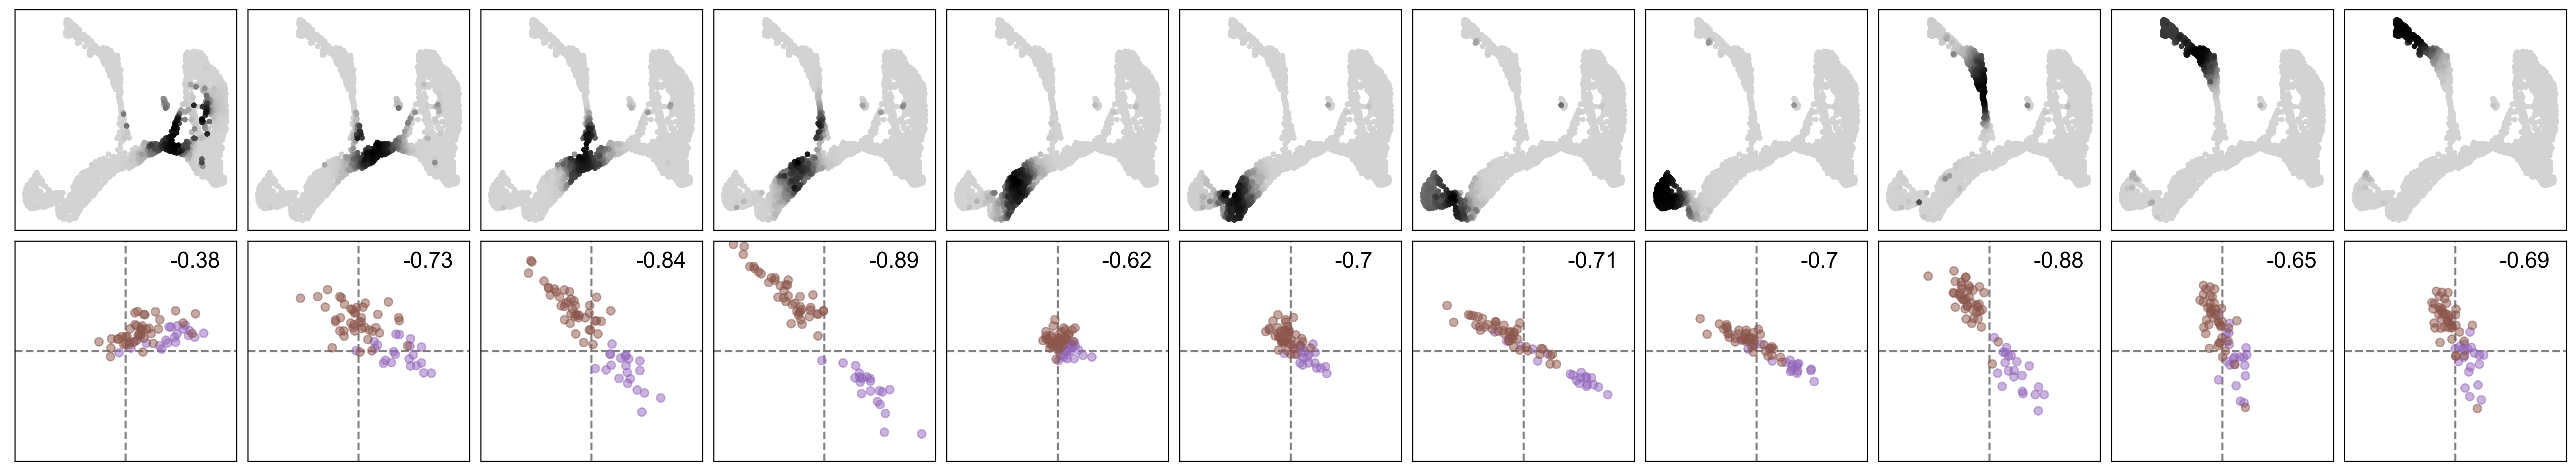

In [32]:
scf.pl.slide_cors(adata,root_milestone="root",milestones=["EN1","EN2"])

We can see a nice repulsion and mutual negative correlation prior to the bifurcation, indicating a possible competition of gene programs prior to the bifurcation. EN2 branch retain the repulsion of modules after bifurcation, this is because this branch keeps expressing early gene module from EN1.

Now we can decrease the cell window size and focus more before the bifurcation:

In [33]:
scf.tl.slide_cells(adata,root_milestone="root",milestones=["EN1","EN2"],win=100)
scf.tl.slide_cors(adata,root_milestone="root",milestones=["EN1","EN2"])

--> added 
    .uns['root->EN1<>EN2']['cell_freq'], probability assignment of cells on 24 non intersecting windows.
--> added 
    .uns['root->EN1<>EN2']['corAB'], gene-gene correlation modules.


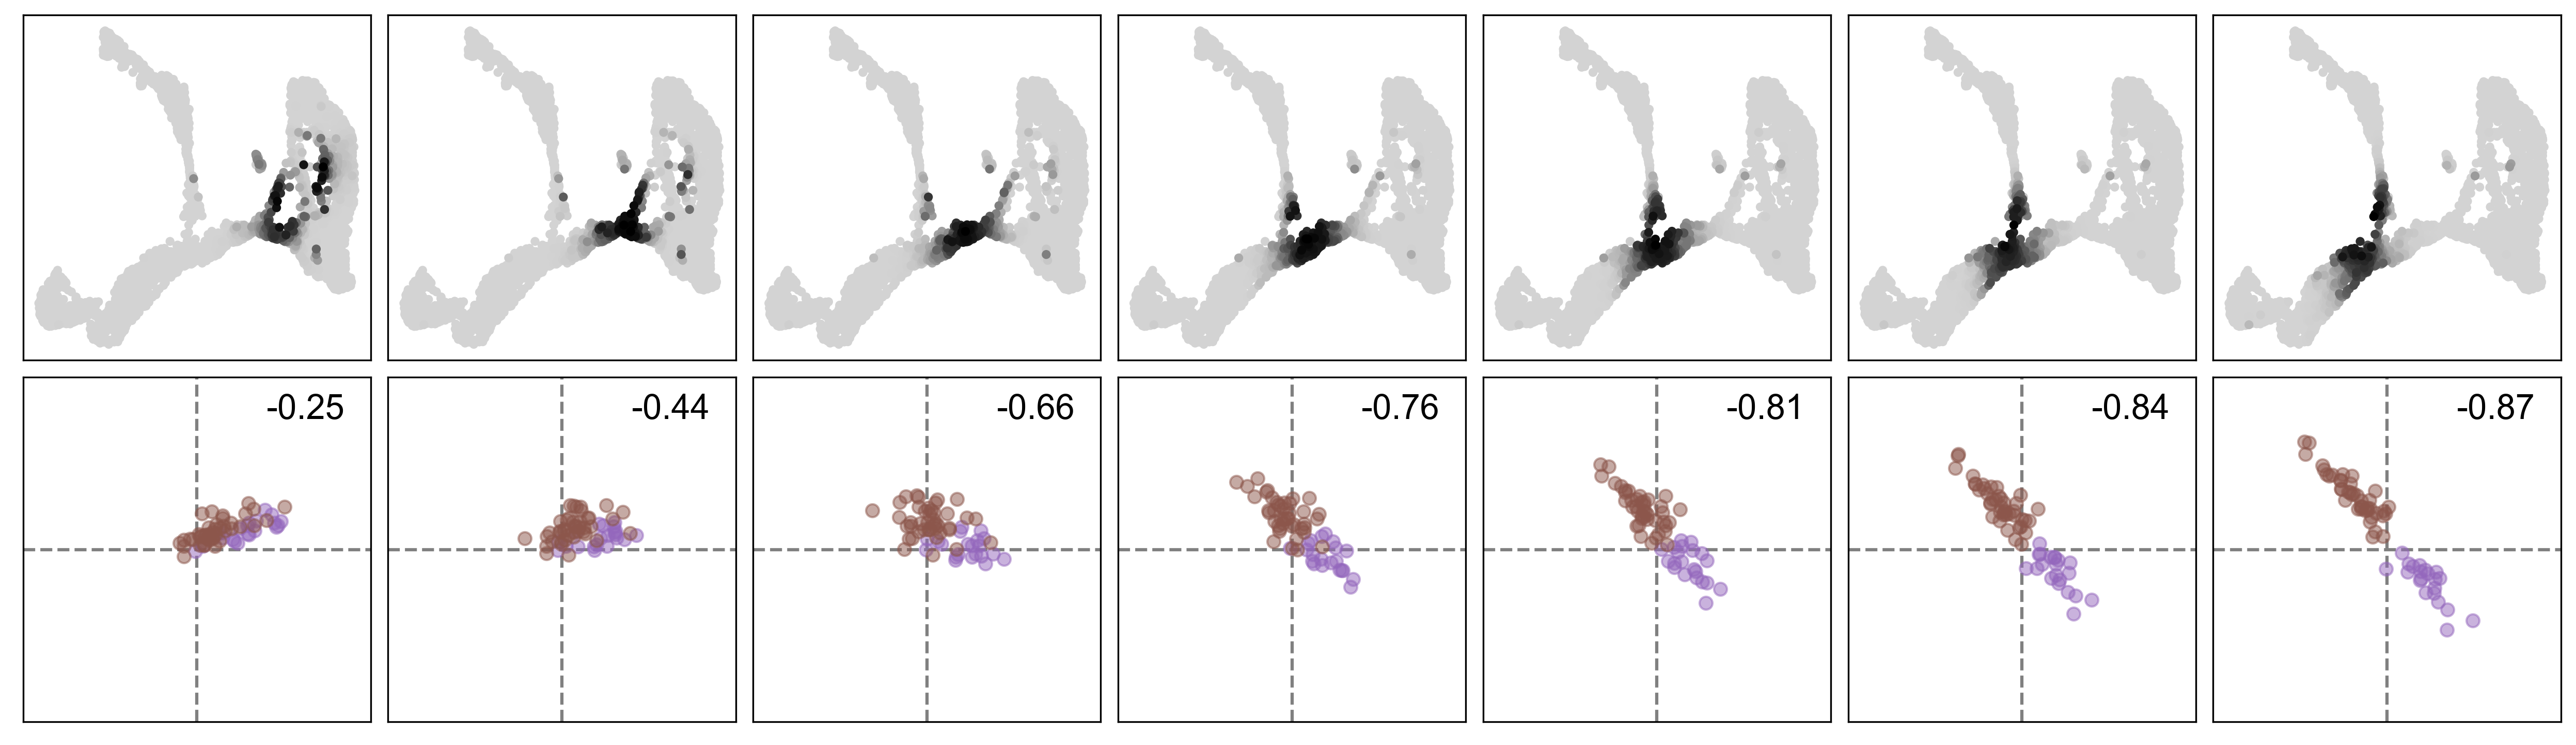

In [34]:
scf.pl.slide_cors(adata,root_milestone="root",milestones=["EN1","EN2"],win_keep=[i for i in range(7)])

### Local trend of module correlations

In order to investigate more precisely the competition of programs prior to bifurcation, we can compute local correlation on a sliding intersecting windows of cells:

In [35]:
scf.tl.synchro_path(adata,root_milestone="root",milestones=["EN1","EN2"],w=150,step=20)

computing local correlations
    finished (0:00:05) --> added 
    .uns['root->EN1<>EN2']['syncho'], mean local gene-gene correlations of all possible gene pairs inside one module, or between the two modules.
    .obs['inter_cor root->EN1<>EN2'], loess fit of inter-module mean local gene-gene correlations prior to bifurcation.


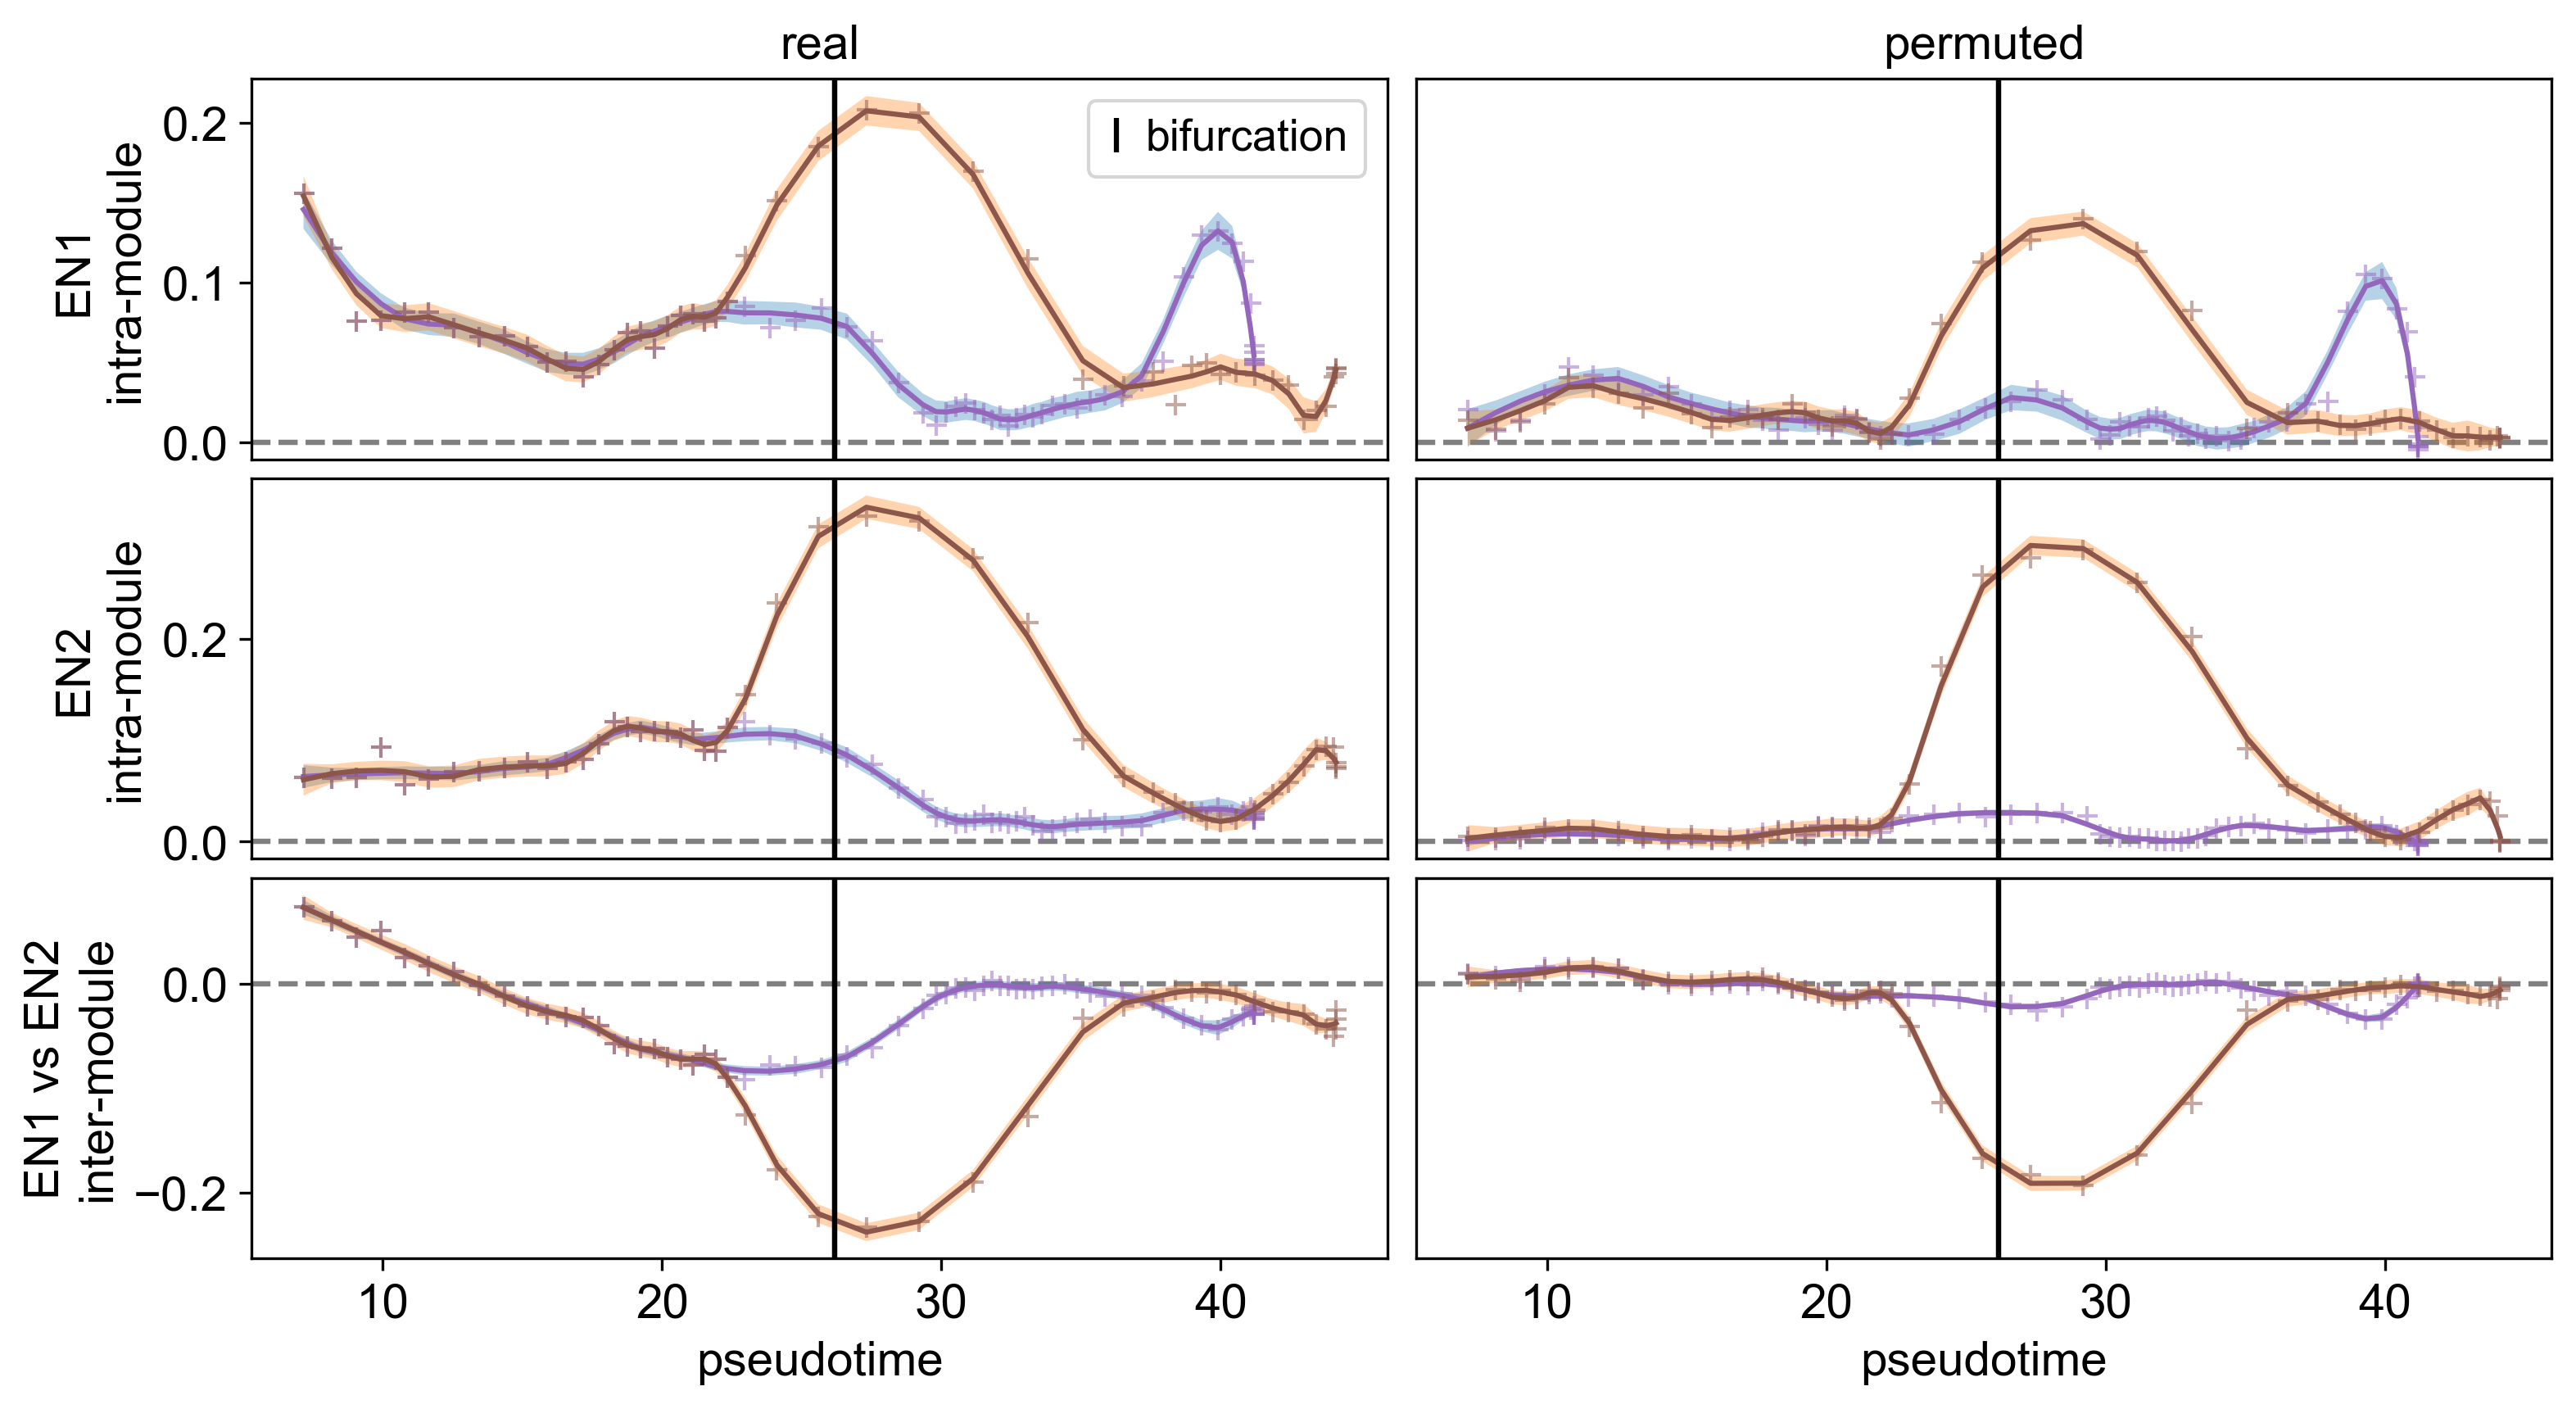

In [36]:
scf.pl.synchro_path(adata,root_milestone="root",milestones=["EN1","EN2"])

Here we see that negative local correlation between the two modules is present at very early pseudotime, quite before the bifurcation. This indicates that cells are already undergoing biasing before reaching the fork.

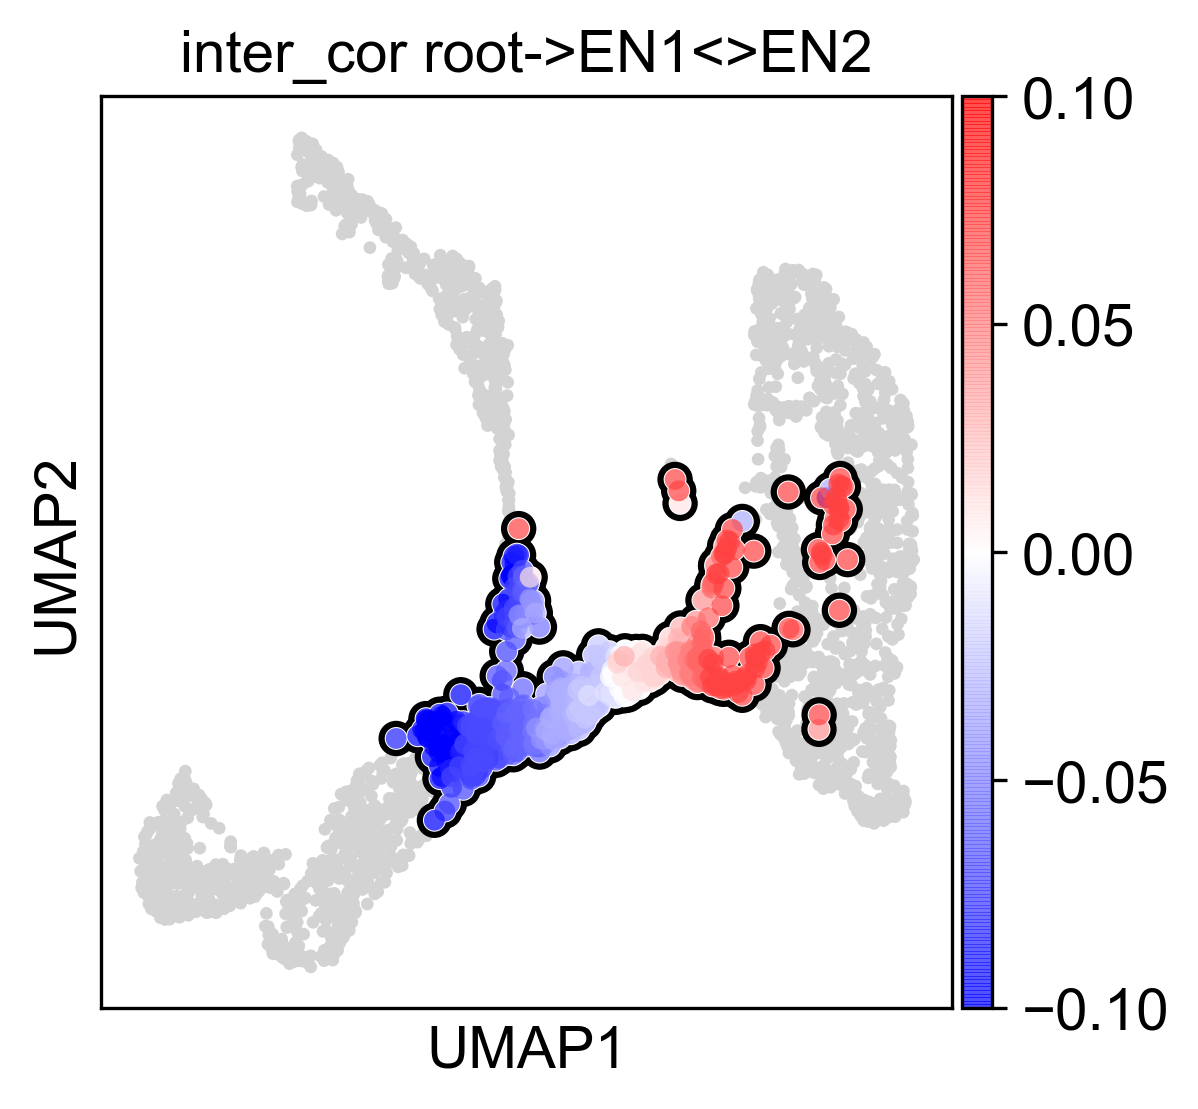

In [37]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
sc.pl.umap(adata,ax=ax,show=False)
sc.pl.umap(adata[~np.isnan(adata.obs["inter_cor root->EN1<>EN2"]),],
           color="inter_cor root->EN1<>EN2",
           add_outline=True,vmin=-0.1,vmax=0.1,
           color_map="bwr",ax=ax,s=100)